In [10]:
# custom analysis tools
from analysis.scan import scan
from analysis.tools import plot_it
from analysis.tools import get_diff
from analysis.tools import extract_species

# useful python libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.optimize import curve_fit
import pandas as pd

# system modules
from IPython import get_ipython
import os

In [11]:
STUDY = 'master_neutrons'

# Get the current directory where the Jupyter Notebook is located

current_directory = get_ipython().run_line_magic('pwd', '')

# Extract the local path to 3CS folder
local_path        = current_directory.split('repo_note3cs')[0]

# Define path to study within data3cs folder
path_to_study     = f'repo_data3cs/data3cs/studies/{STUDY}'

# Final path
path              = f'{local_path}{path_to_study}'

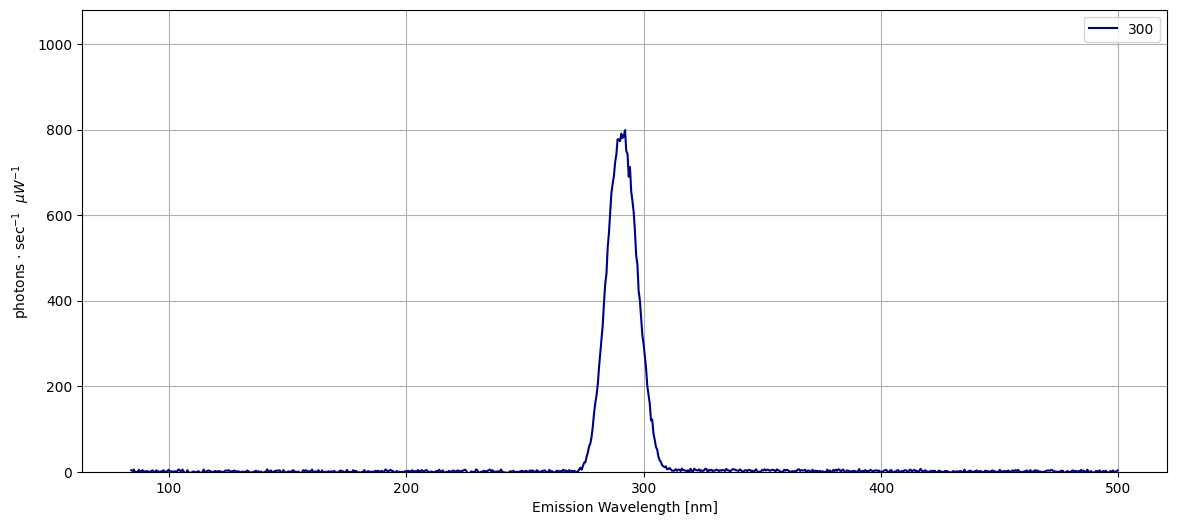

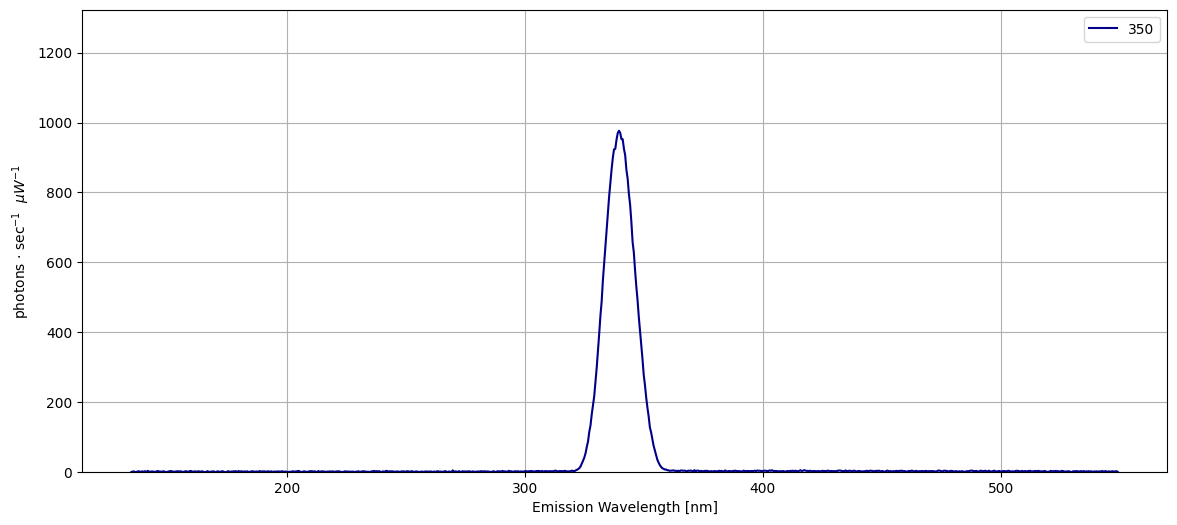

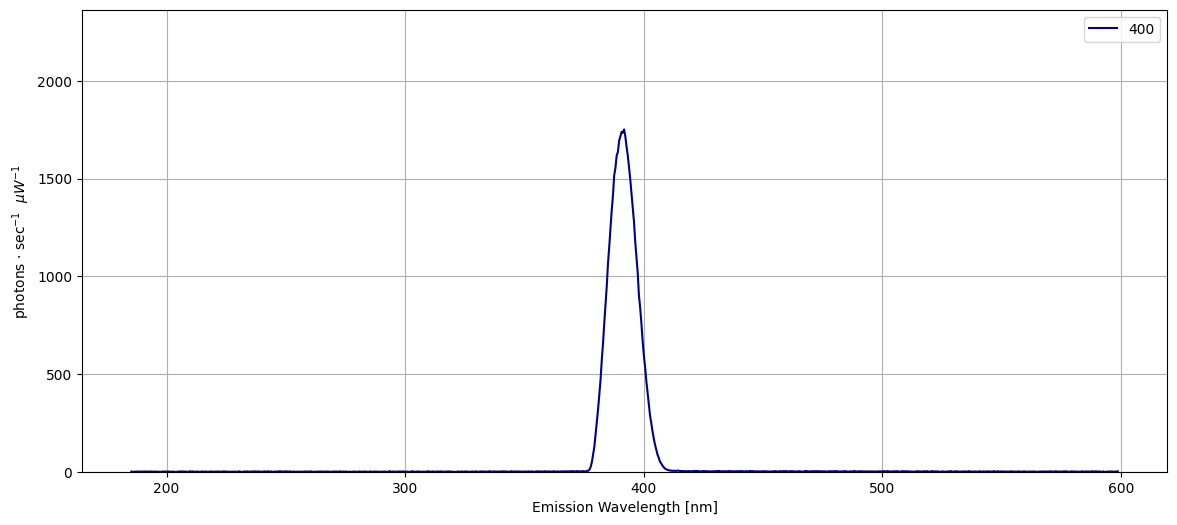

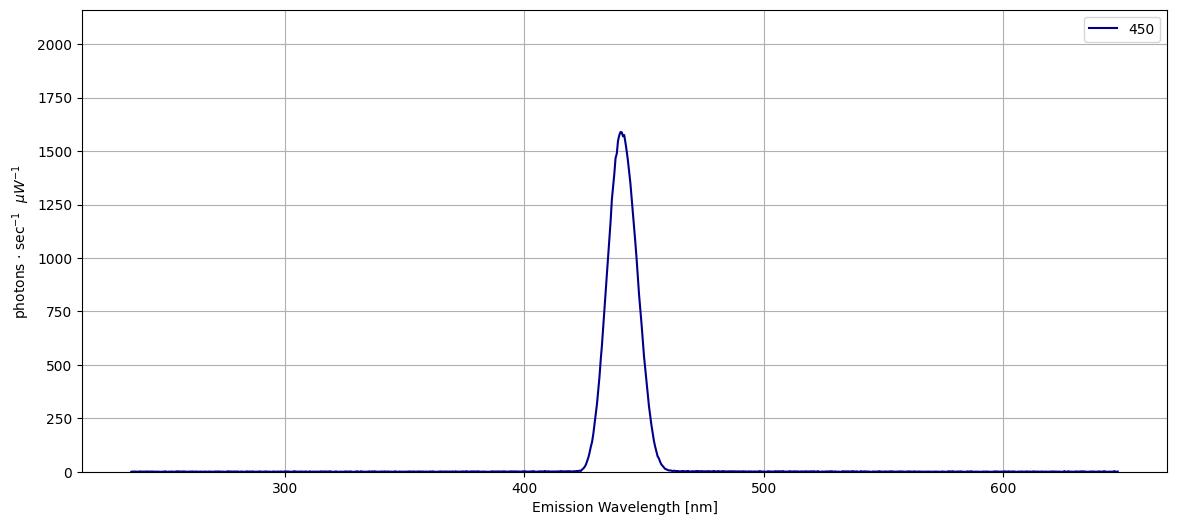

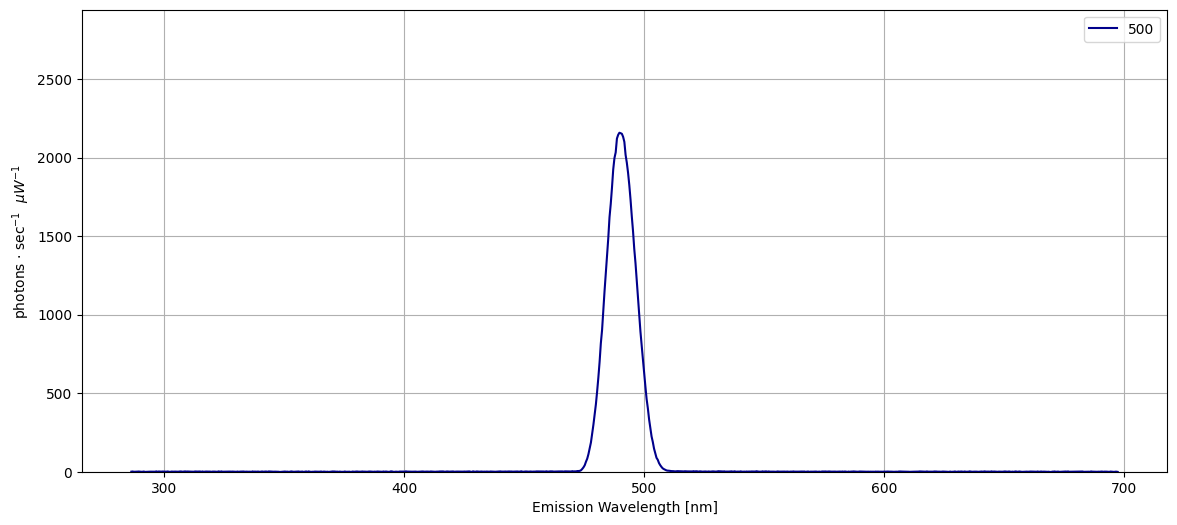

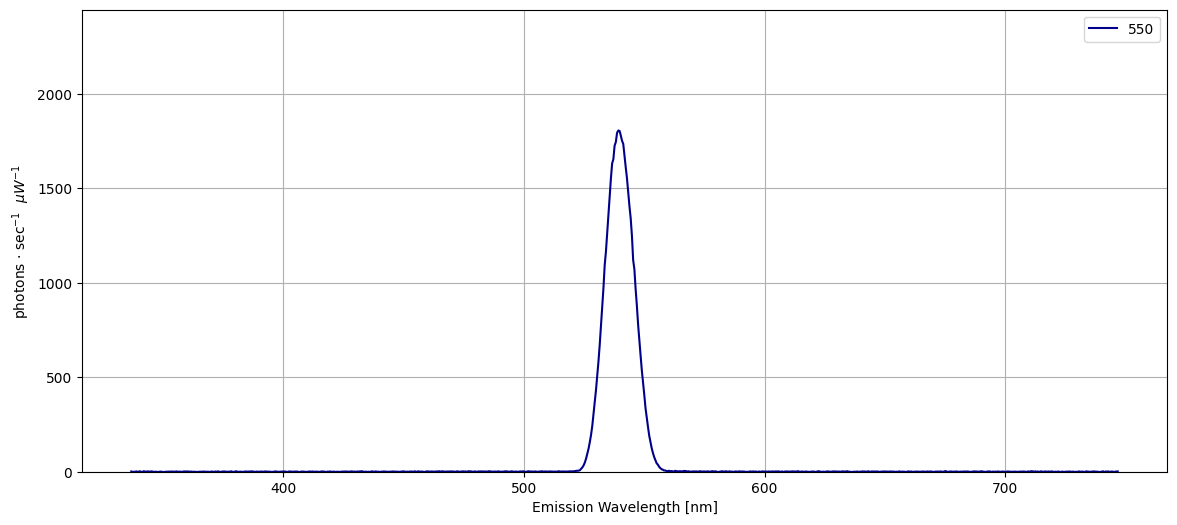

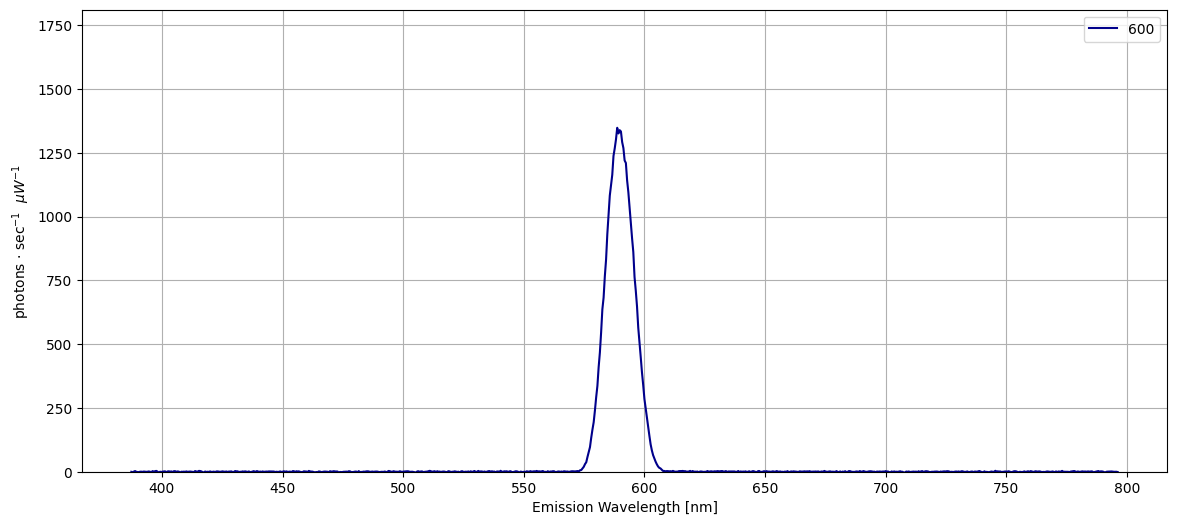

In [12]:
# Crystal name + collection number ZnO_500_1 = crystal ZnO_500, collection 1.
Qz_1 = scan(f'{path}/coll1/Qz_wl/qz_wl.hdf5')
Qz_2 = scan(f'{path}/coll2/Qz_wl/qz_wl.hdf5')
Qz_3 = scan(f'{path}/coll3/Qz_wl/qz_wl.hdf5')
Qz_3.df
for wl in np.arange(300,650,50):
    plt.figure()
    plot_it(Qz_3, f'{wl}', '1.0', it=0, label=f'{wl}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

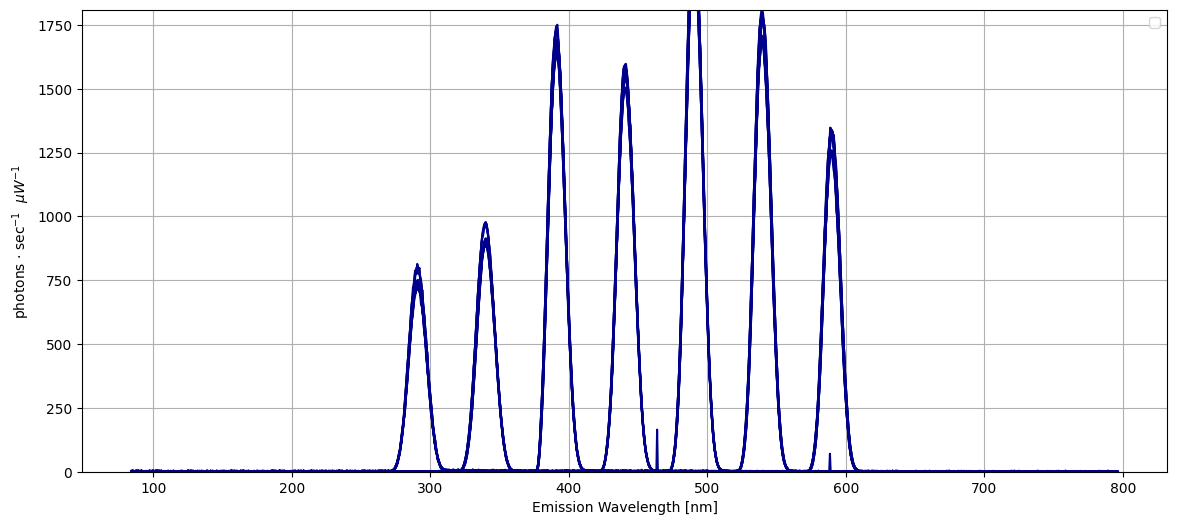

In [13]:
# This saves data in a dictionary
def process_data(data,ex_wl, it):
    wl, spec = plot_it(data, f'{ex_wl}', '1.0', it=it)
    return wl, spec

# Define Qtz Crystals here
Qz_Cry = {
    'Qz_1': Qz_1,
    'Qz_2': Qz_2,
    'Qz_3': Qz_3,
}

# Creating the data an sortting it in a dictionary
processed_data = {}


for key, data in Qz_Cry.items():
    processed_data[key] = {}
    for ex_wl in range(300,650,50):
        processed_data[key][ex_wl] = {}
        # Iterate over the values of "it" from 0 to 3 and process the data
        for it in range(4):
            wl, spec = process_data(data, ex_wl,it)
            processed_data[key][ex_wl][it] = {'wl': wl, 'spec': spec}

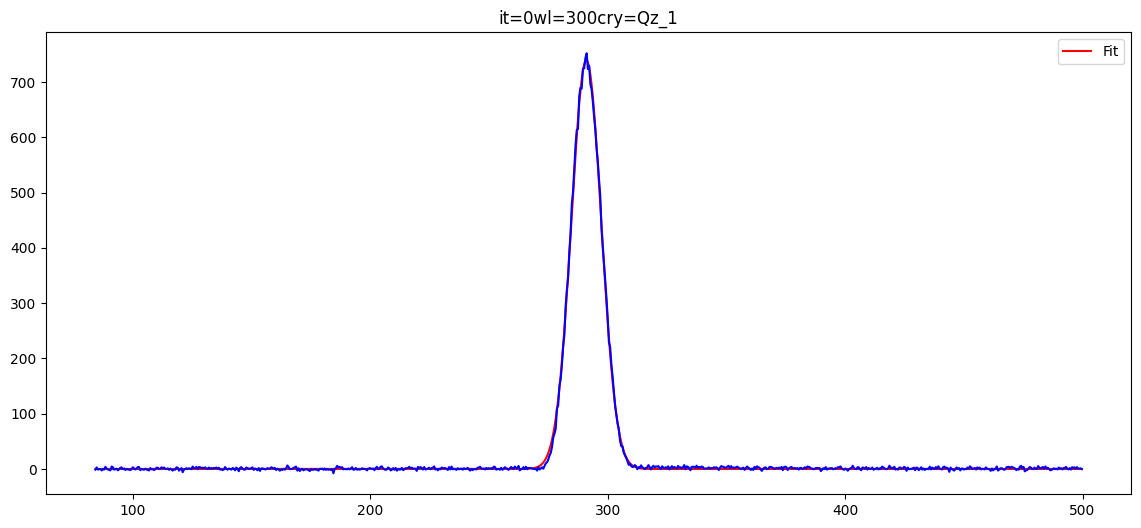

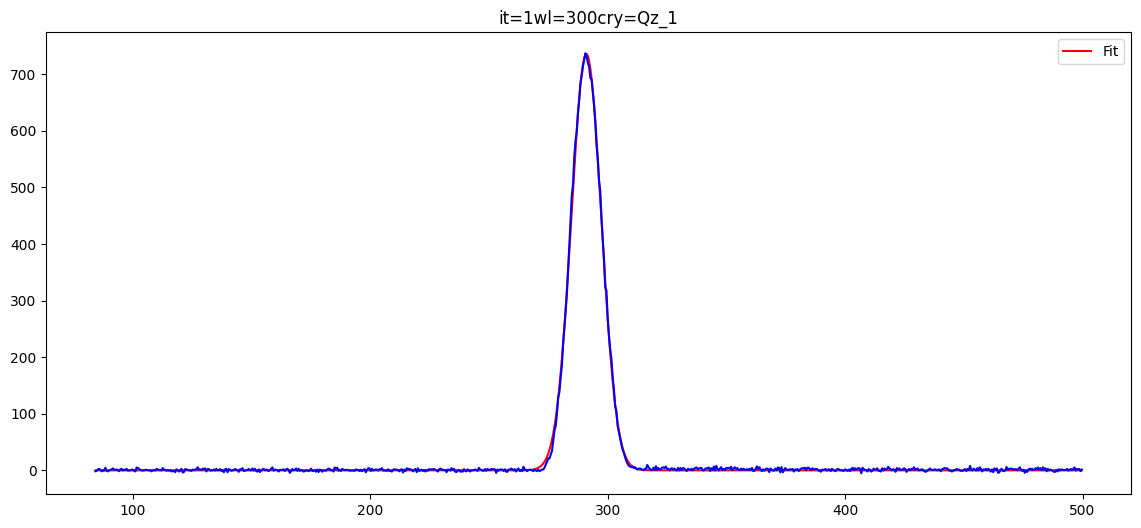

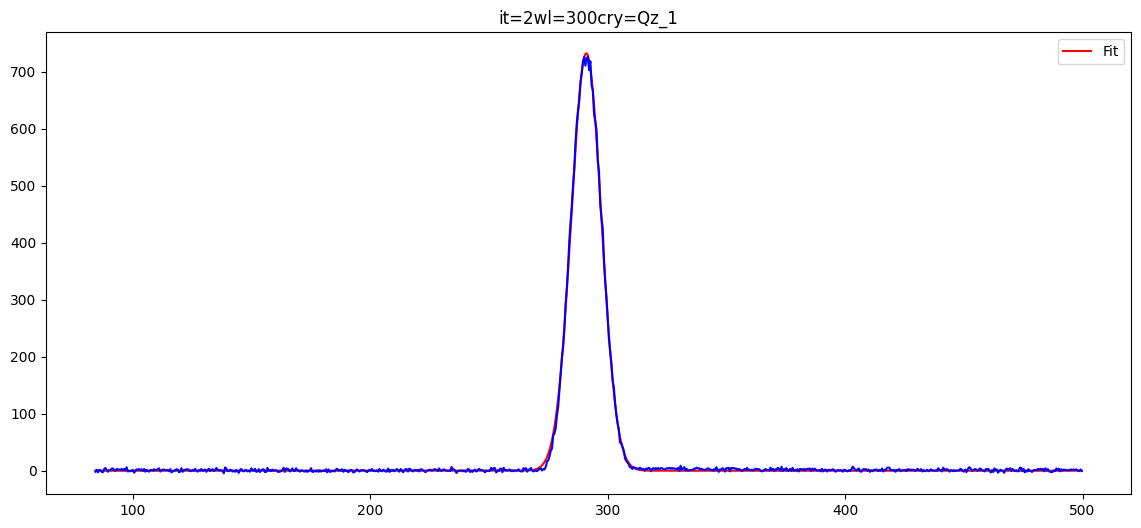

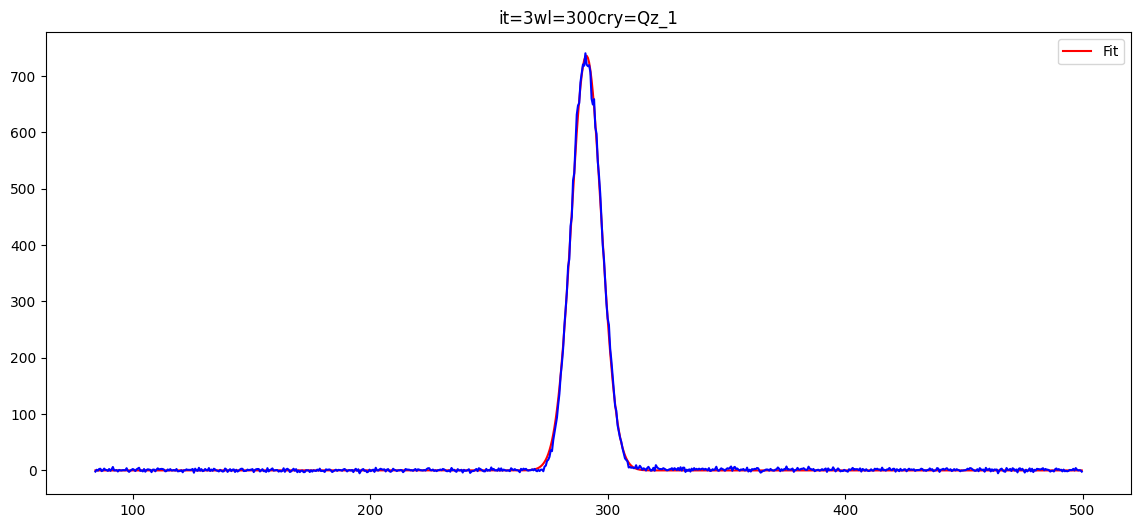

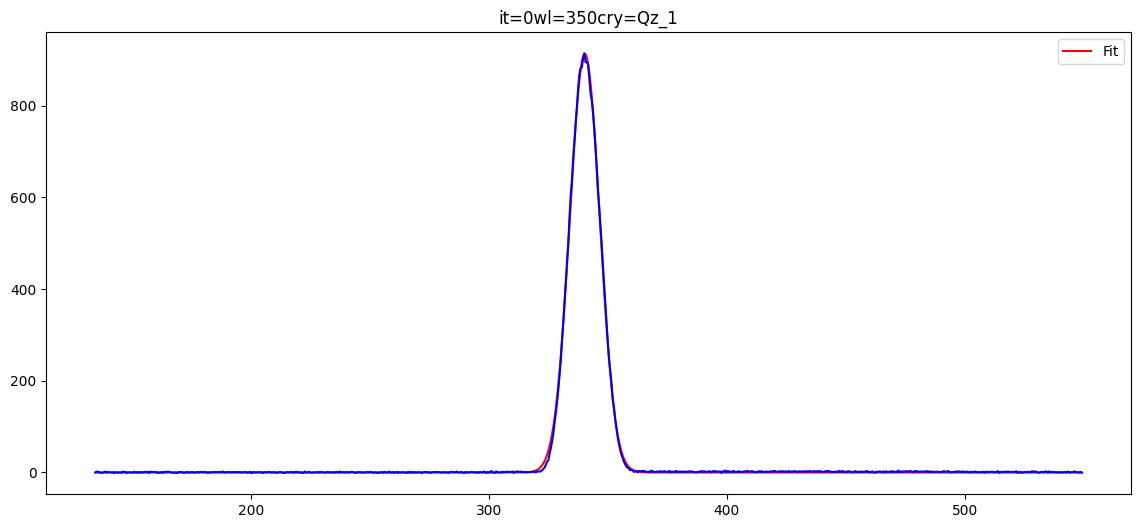

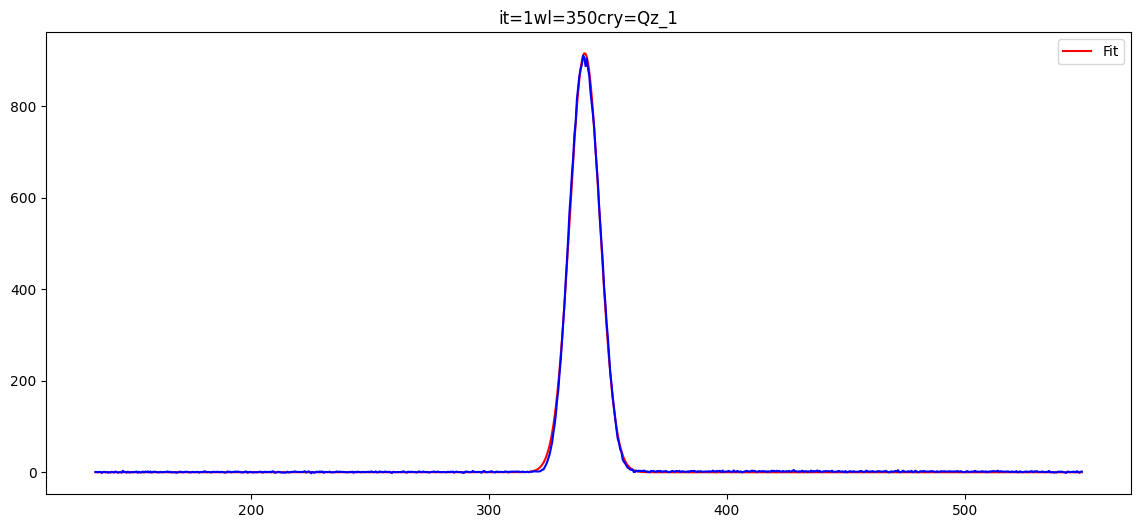

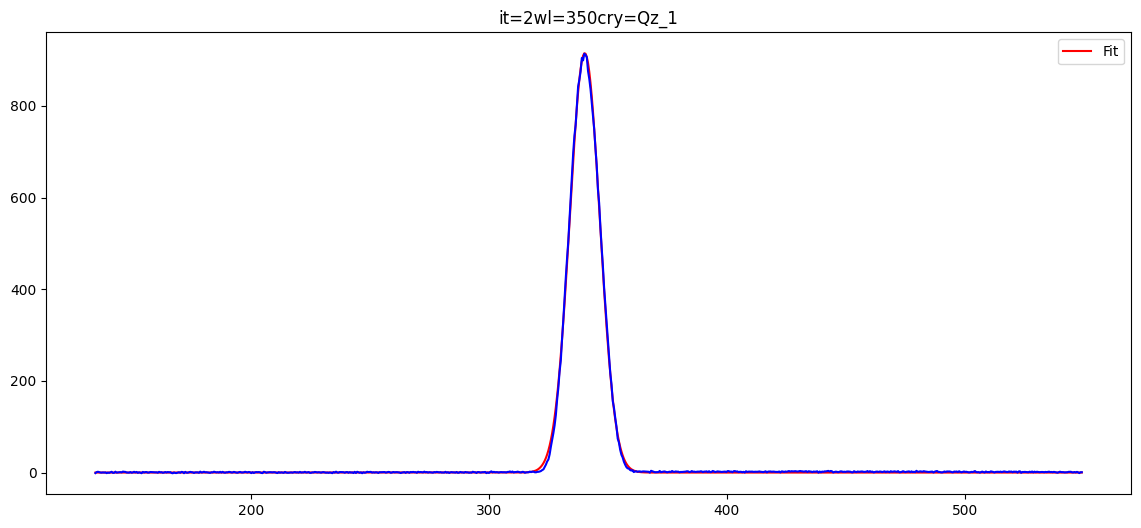

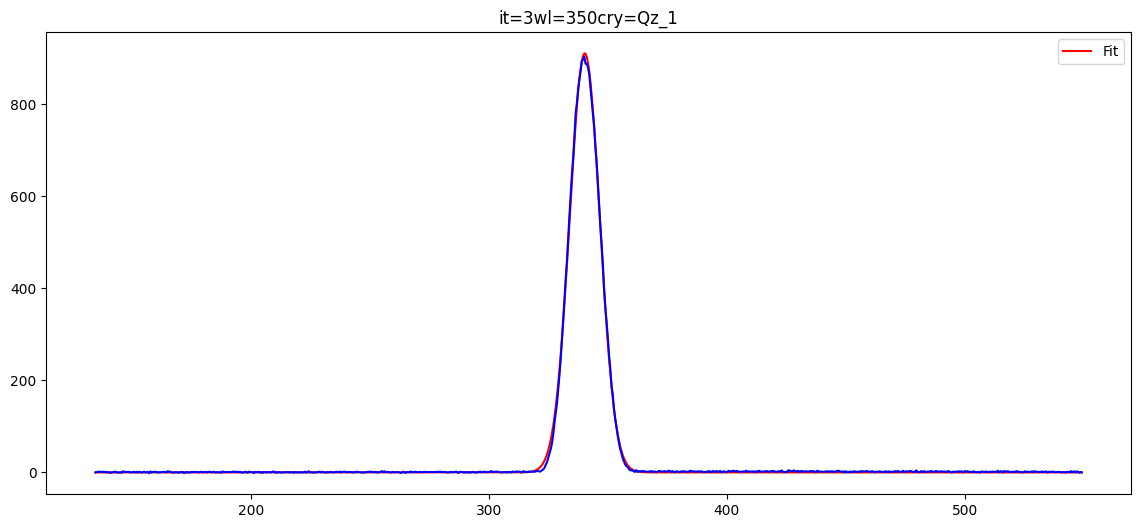

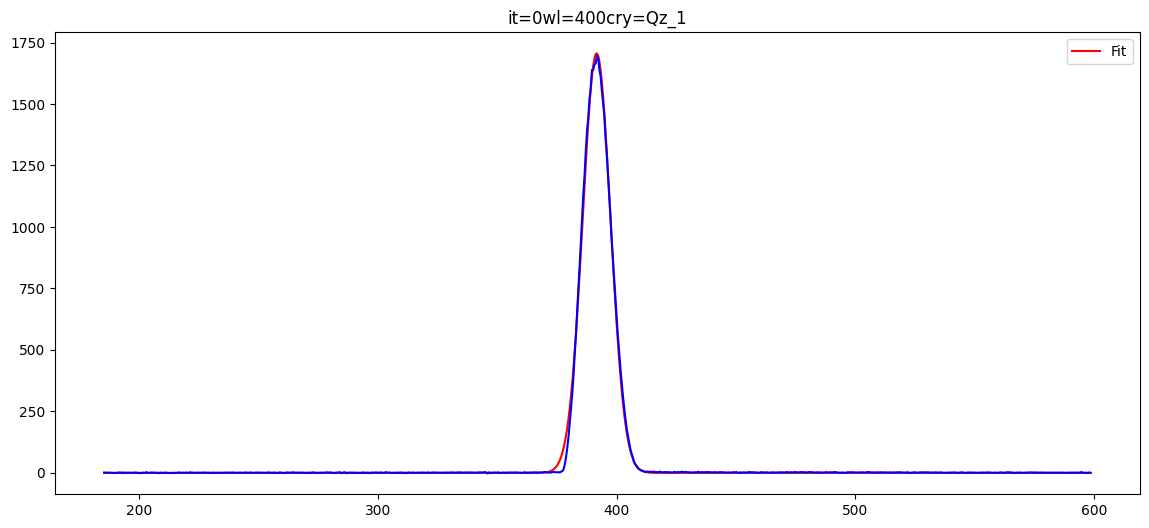

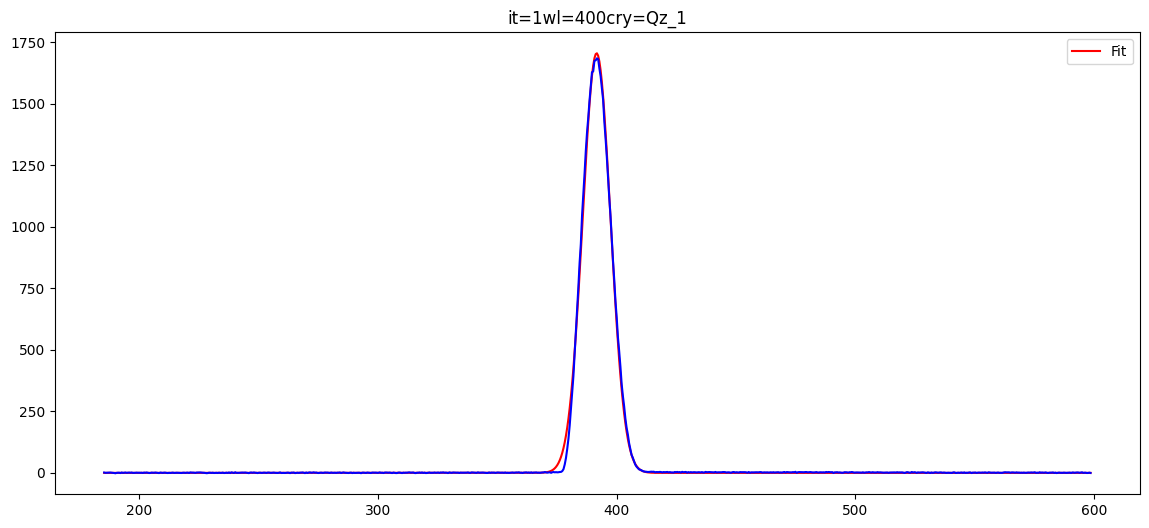

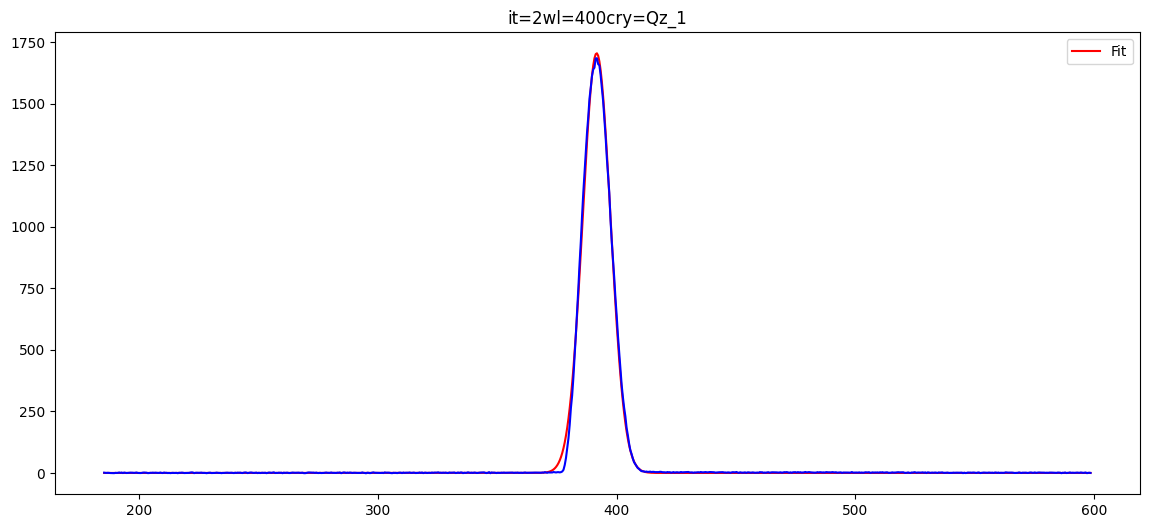

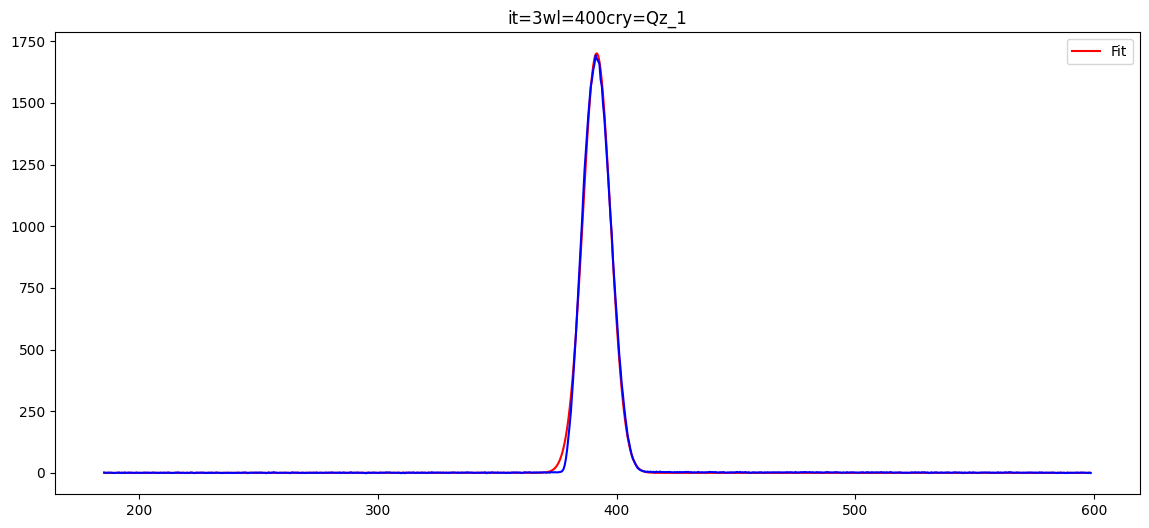

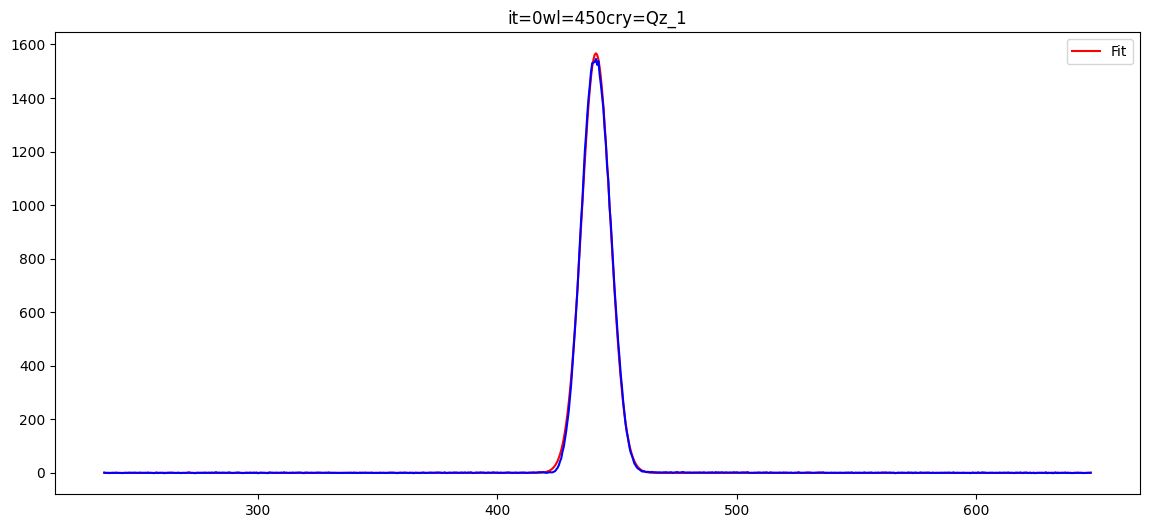

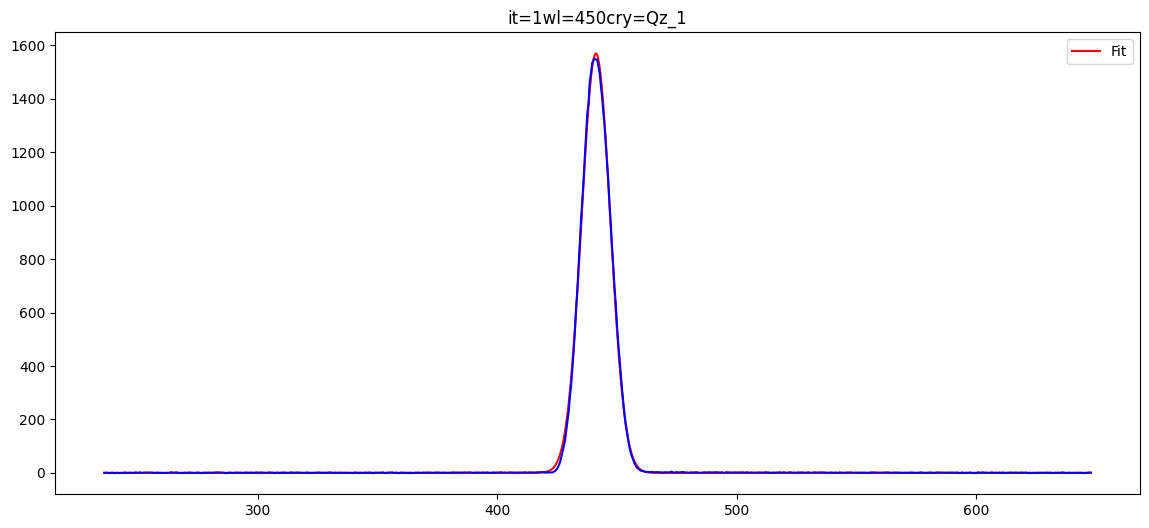

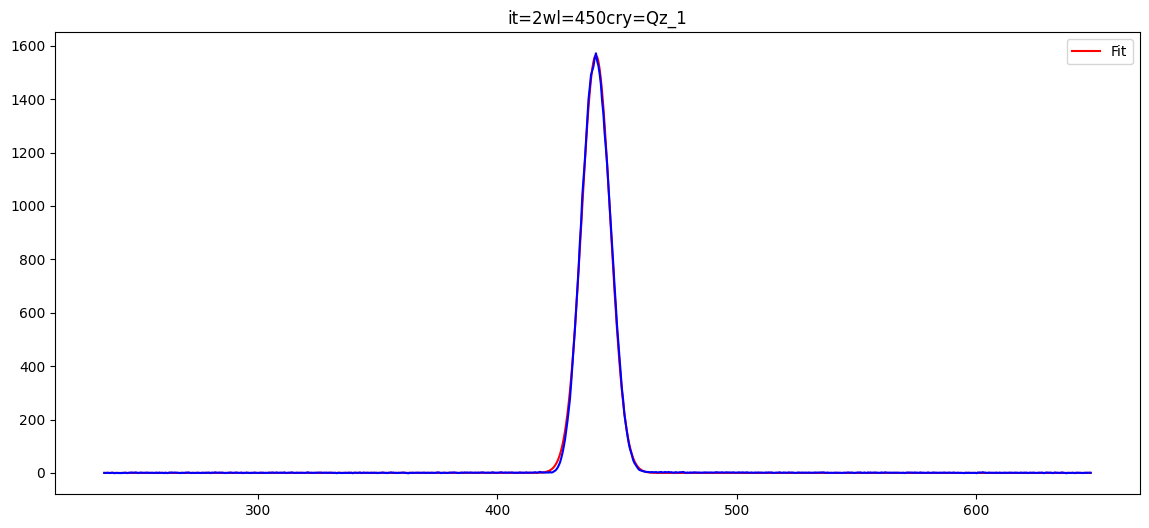

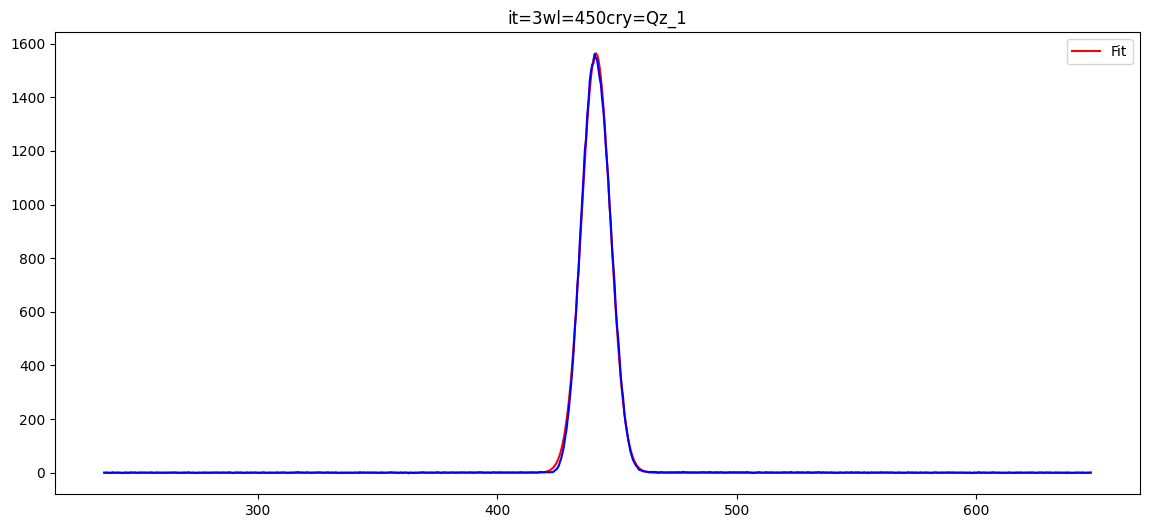

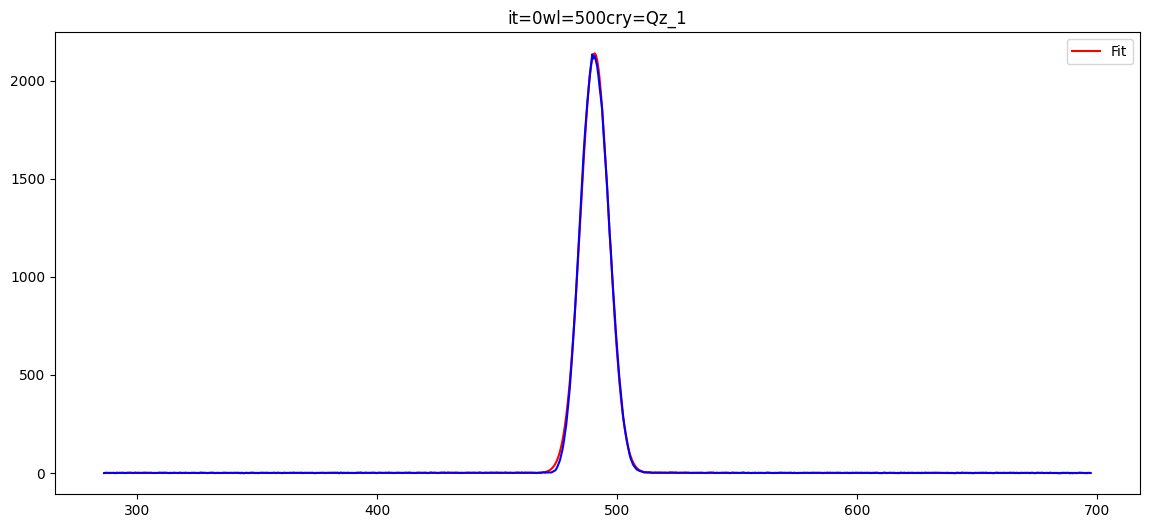

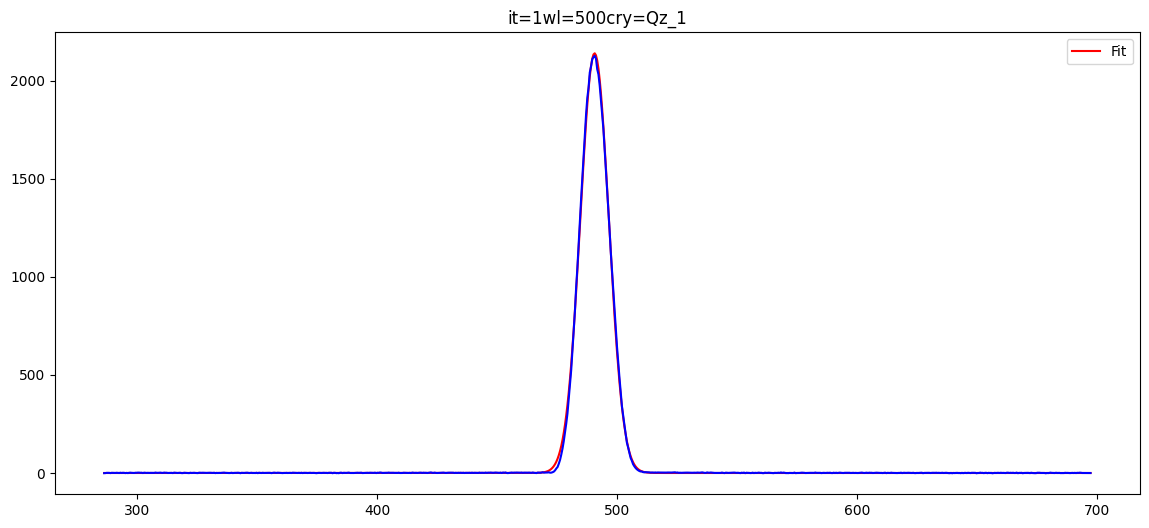

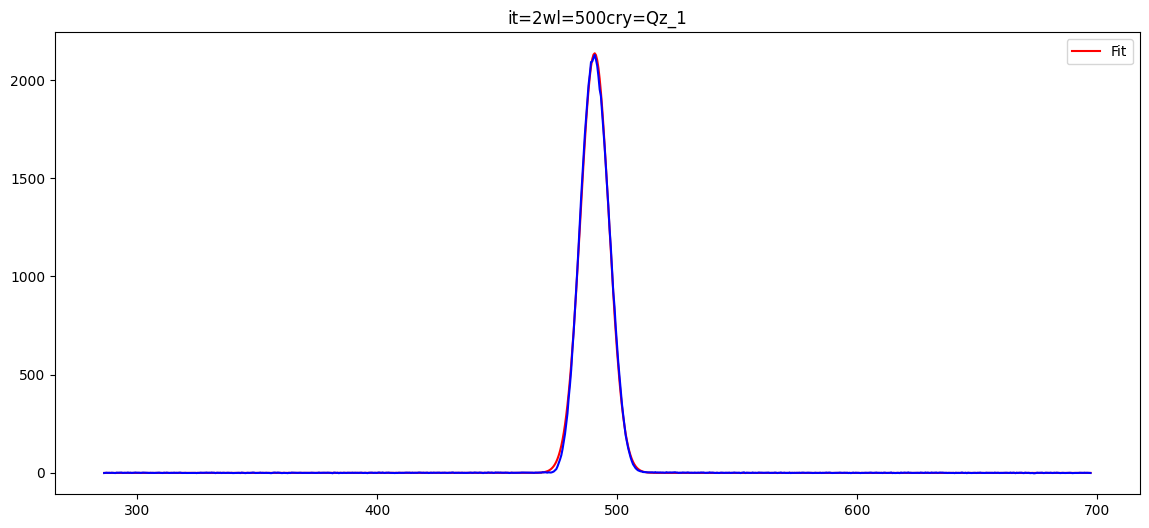

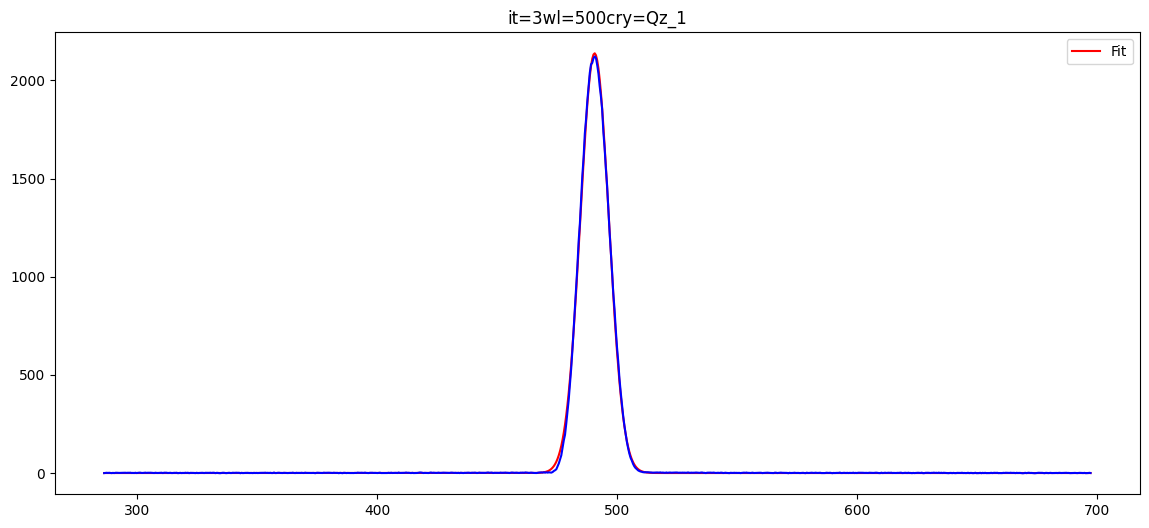

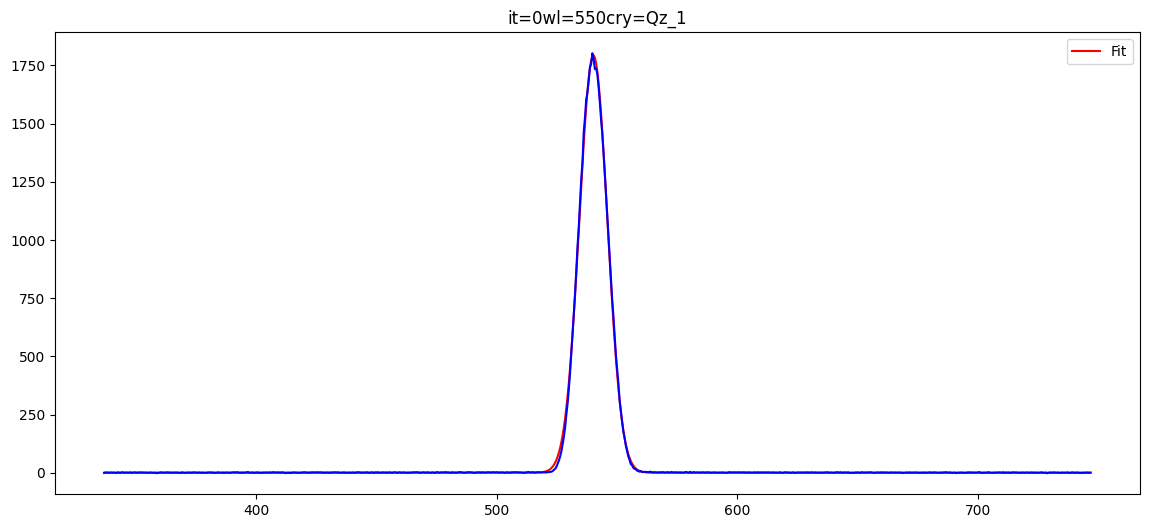

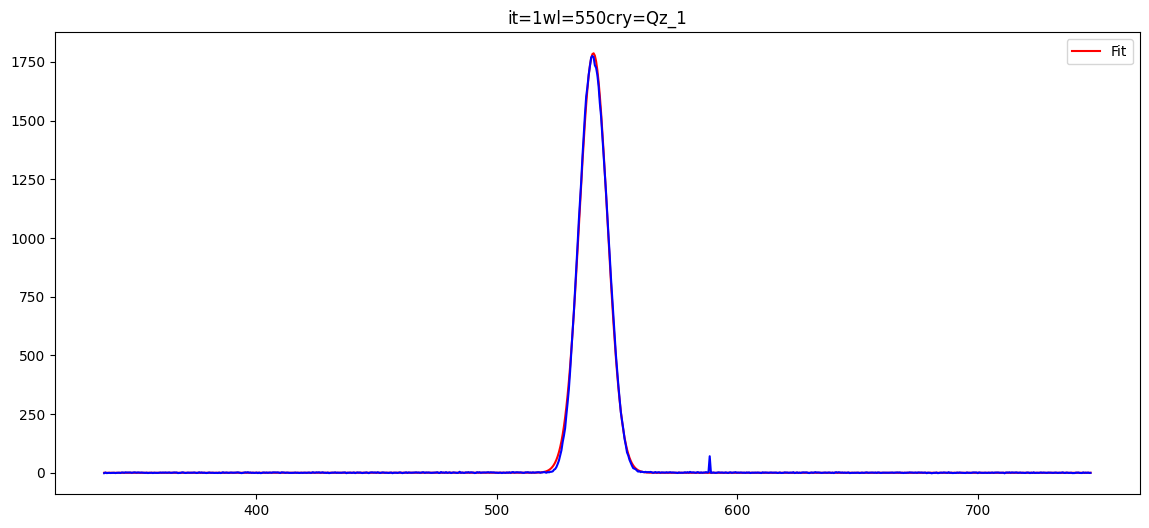

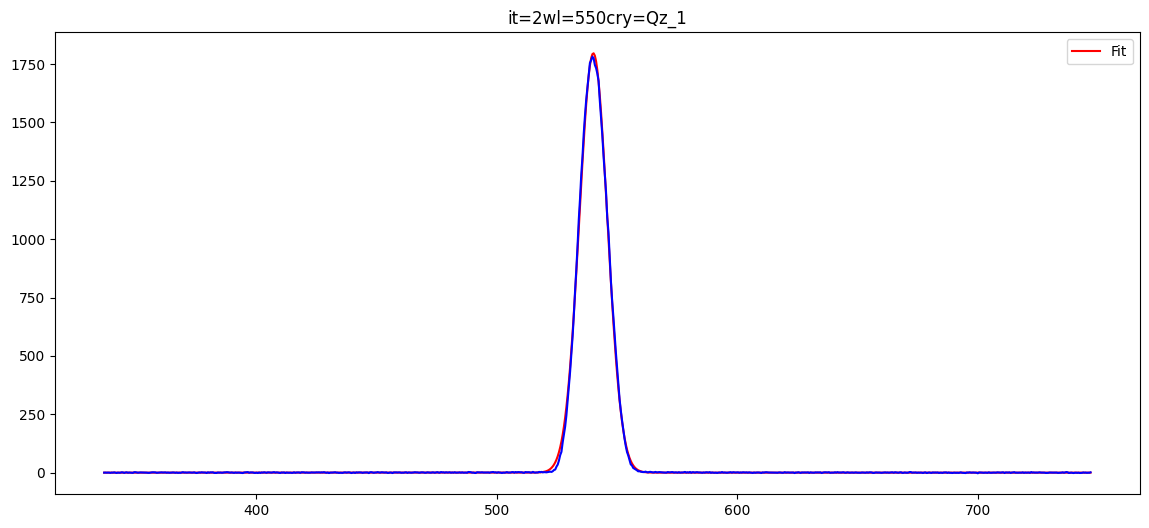

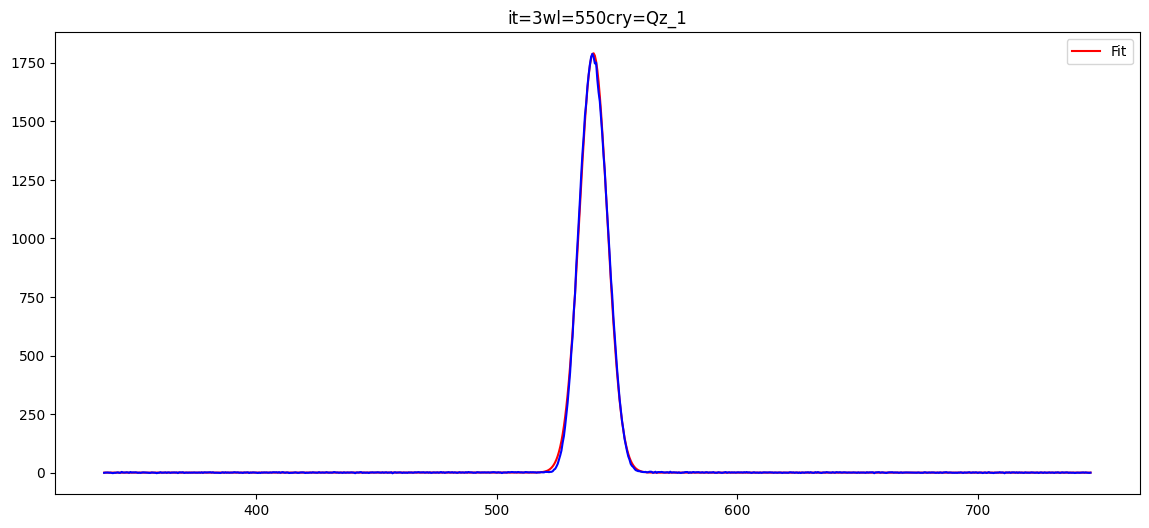

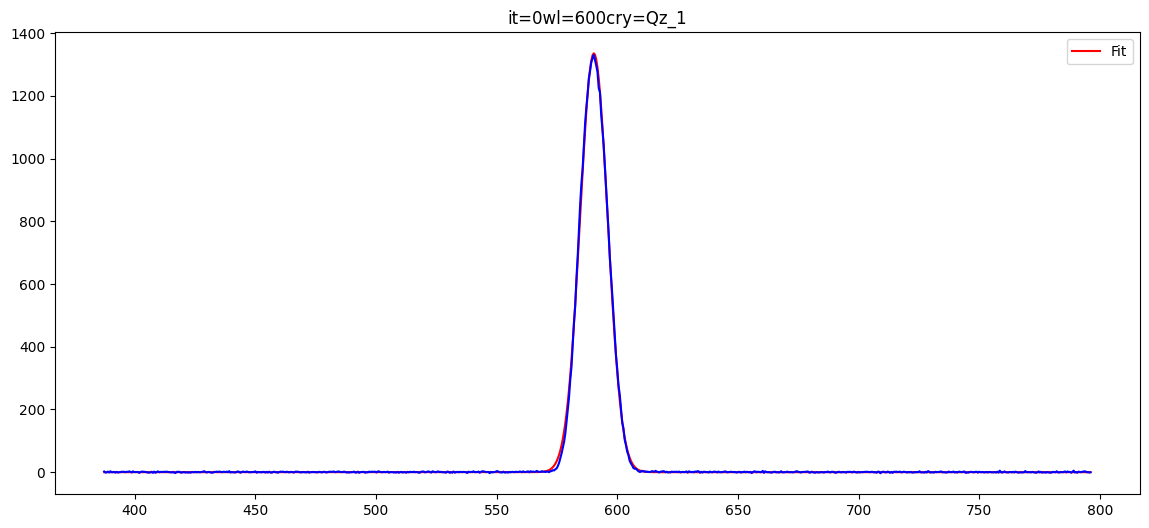

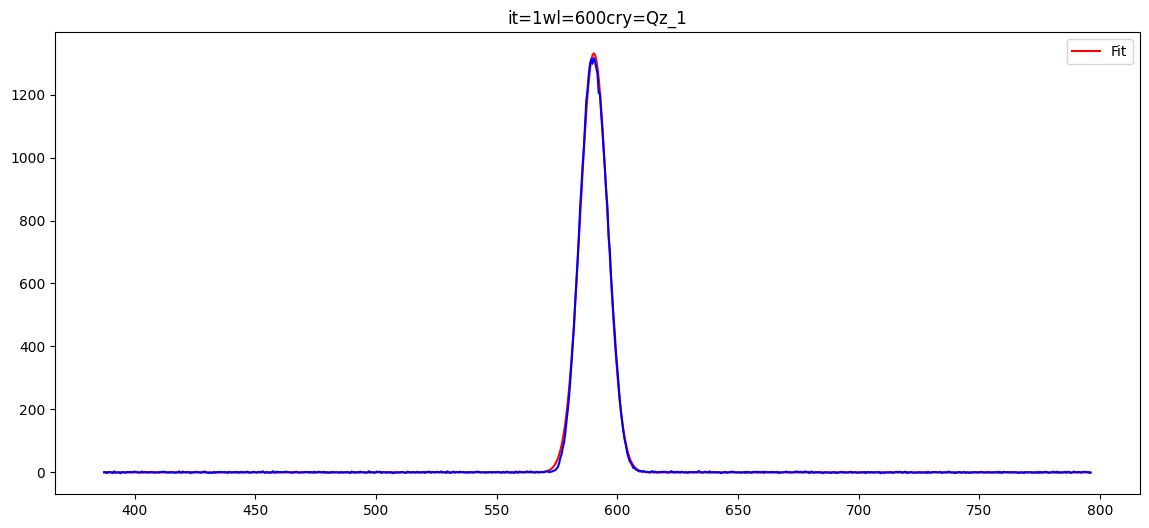

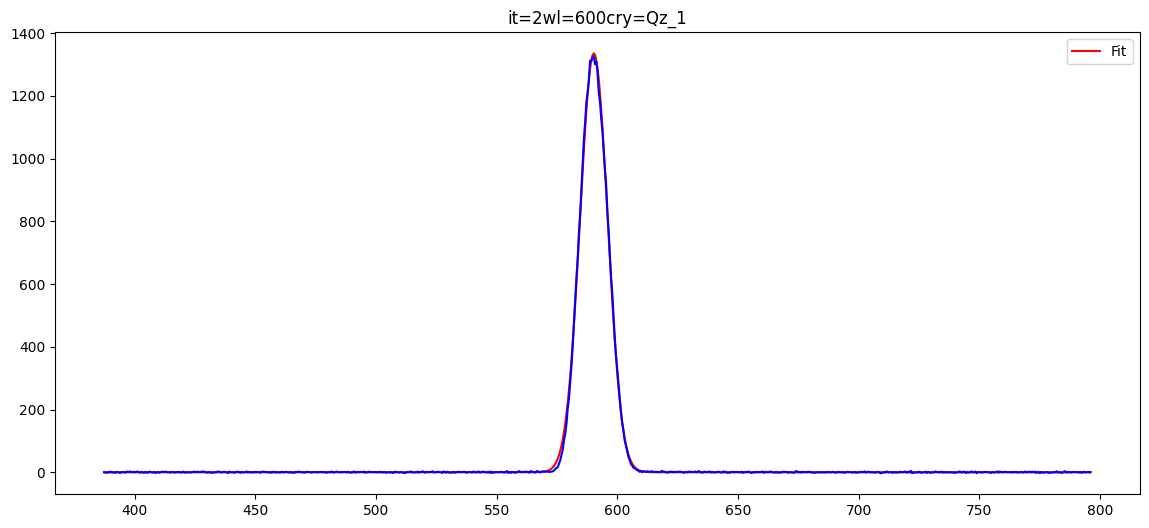

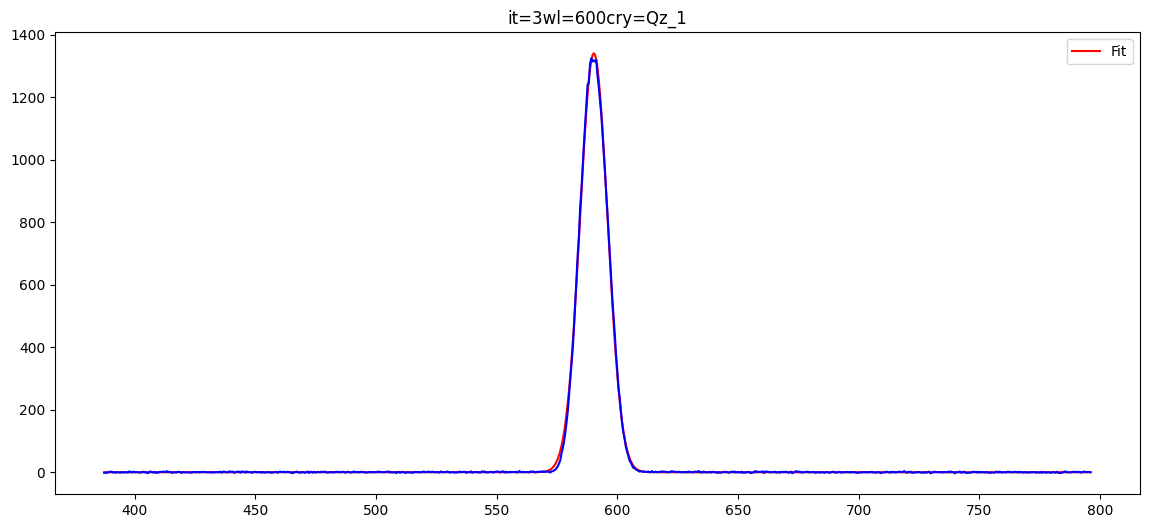

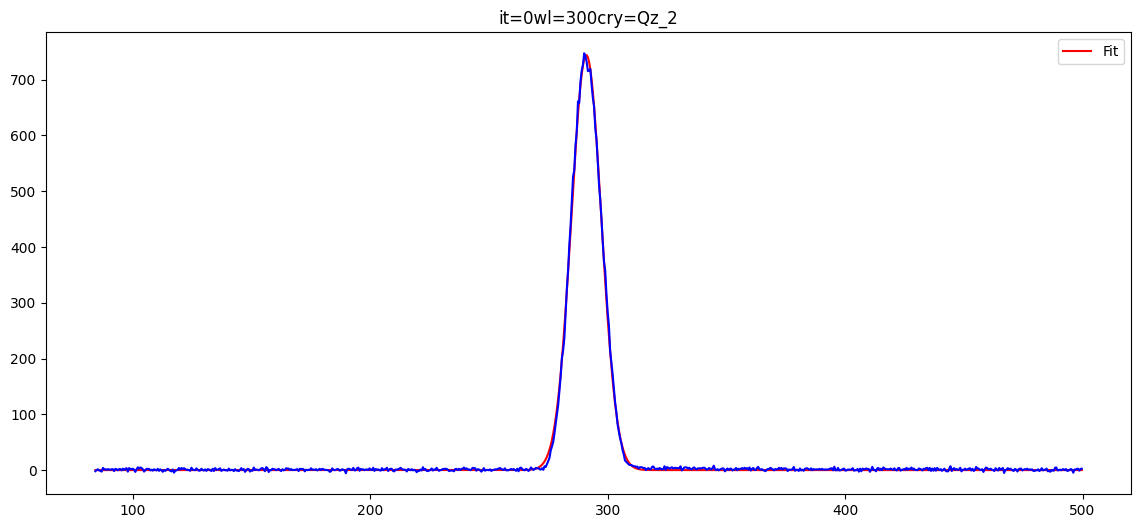

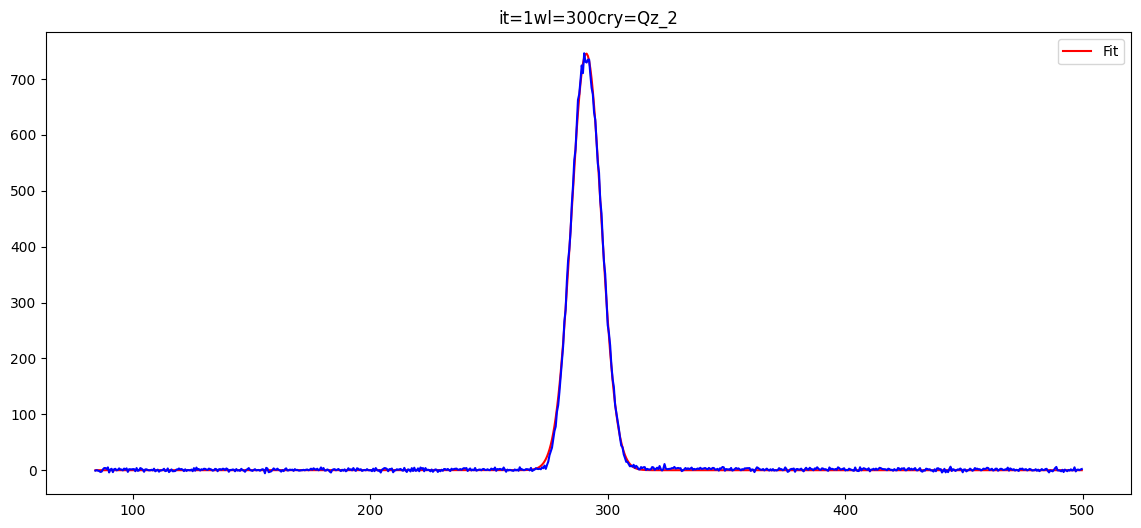

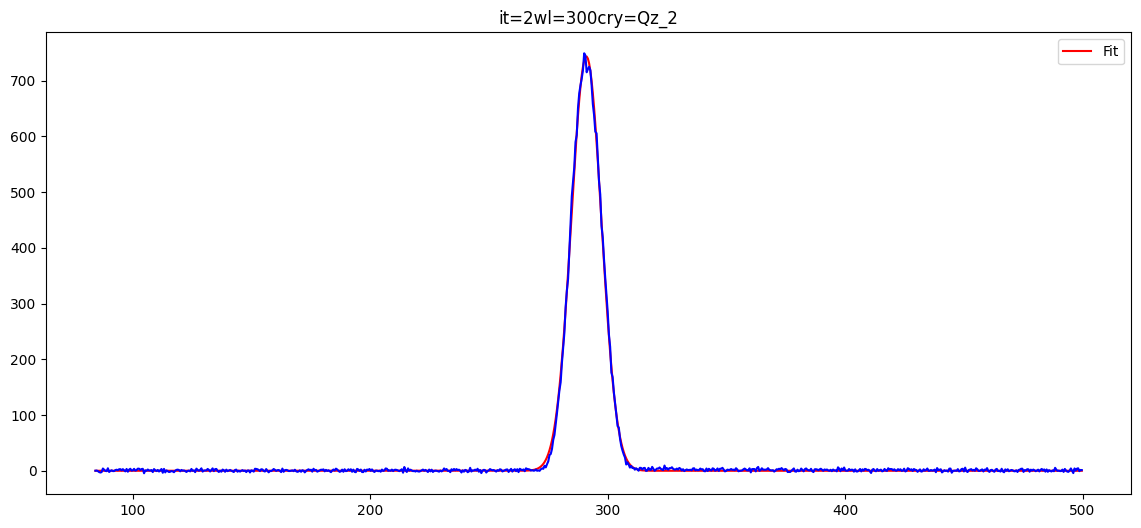

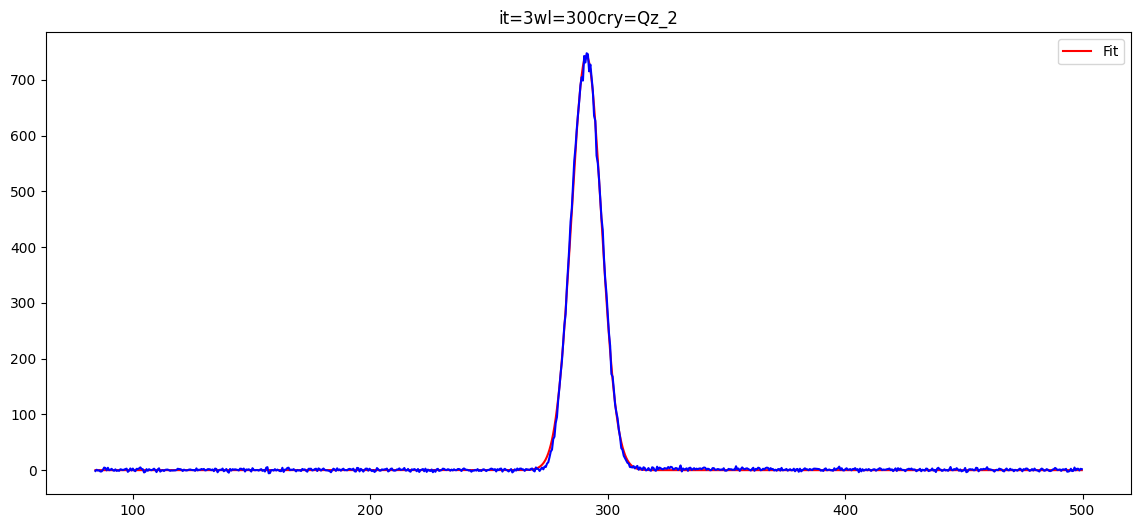

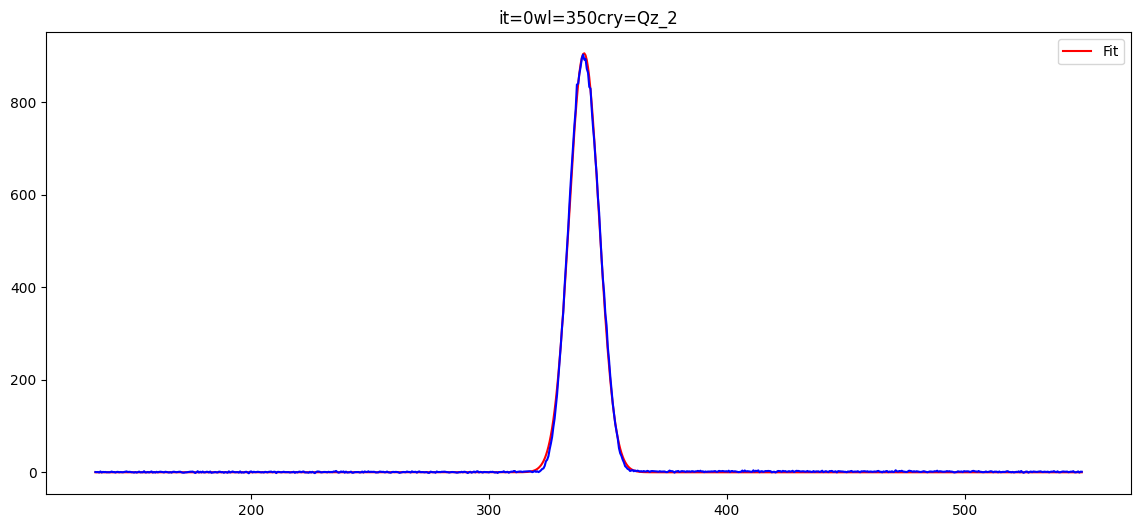

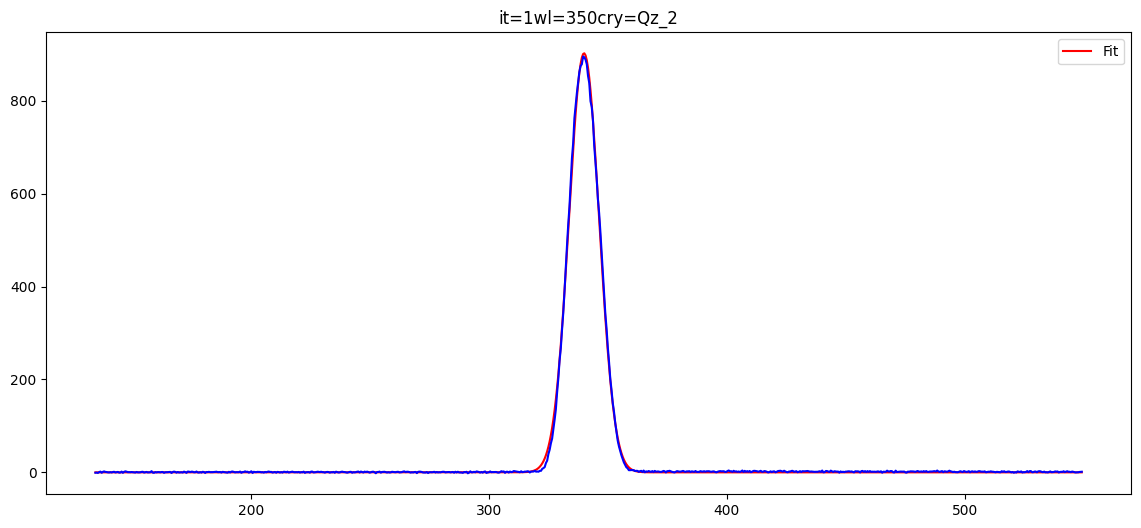

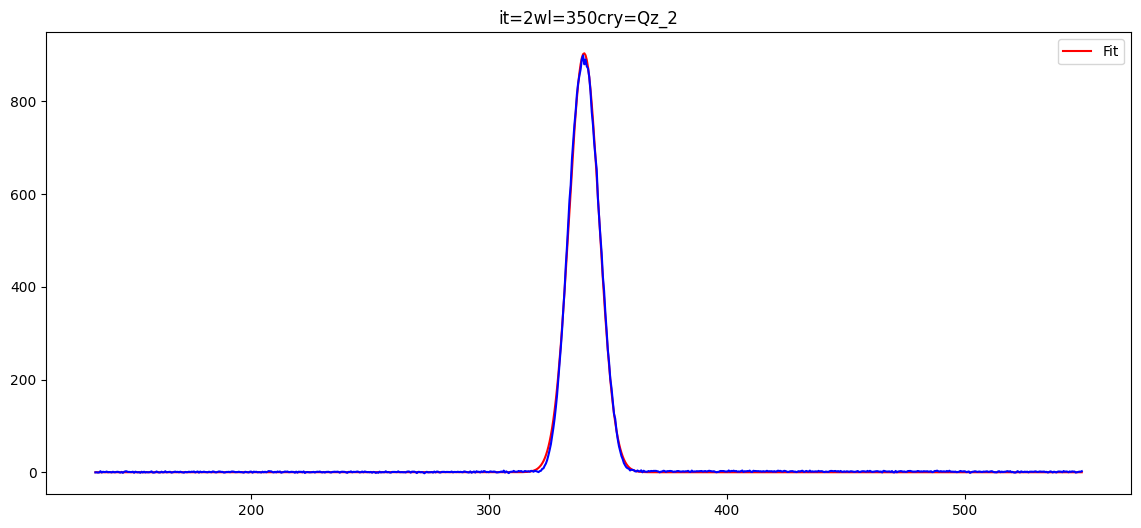

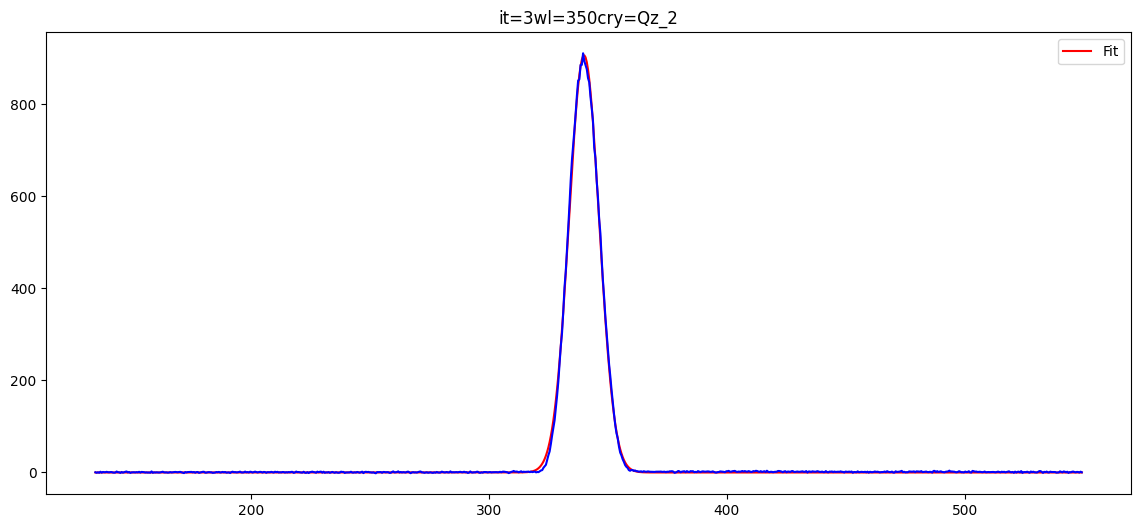

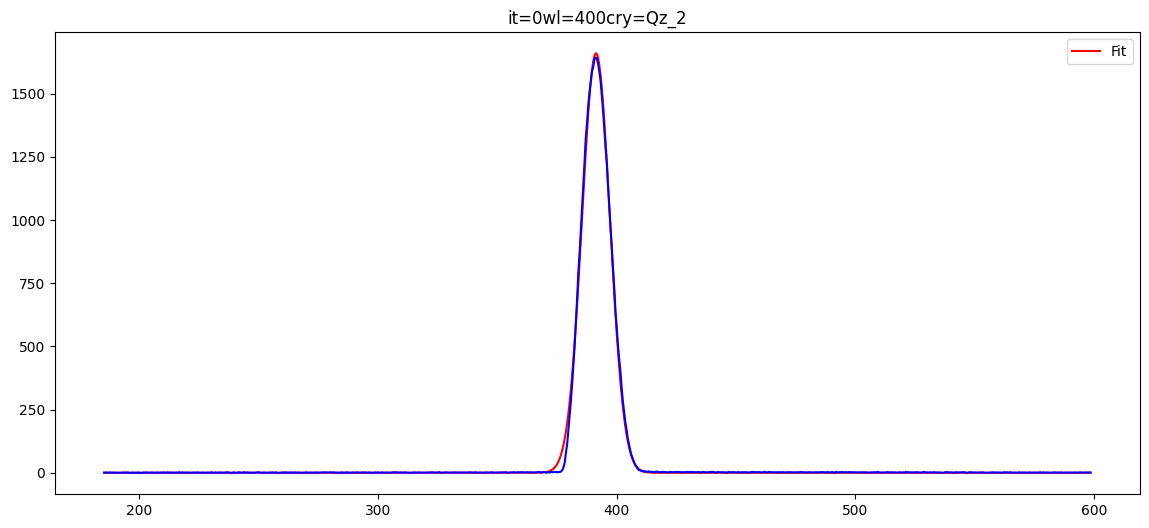

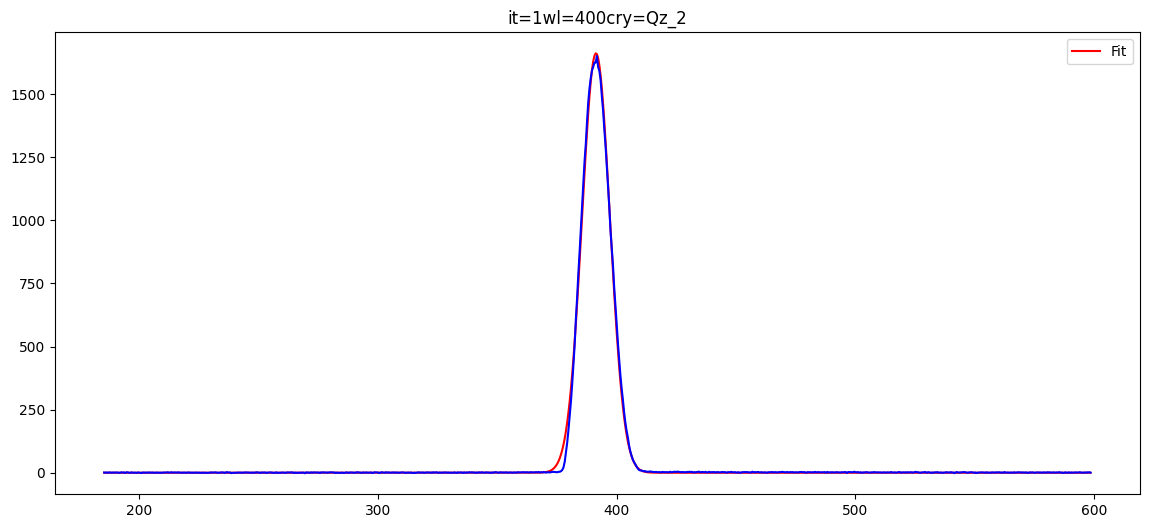

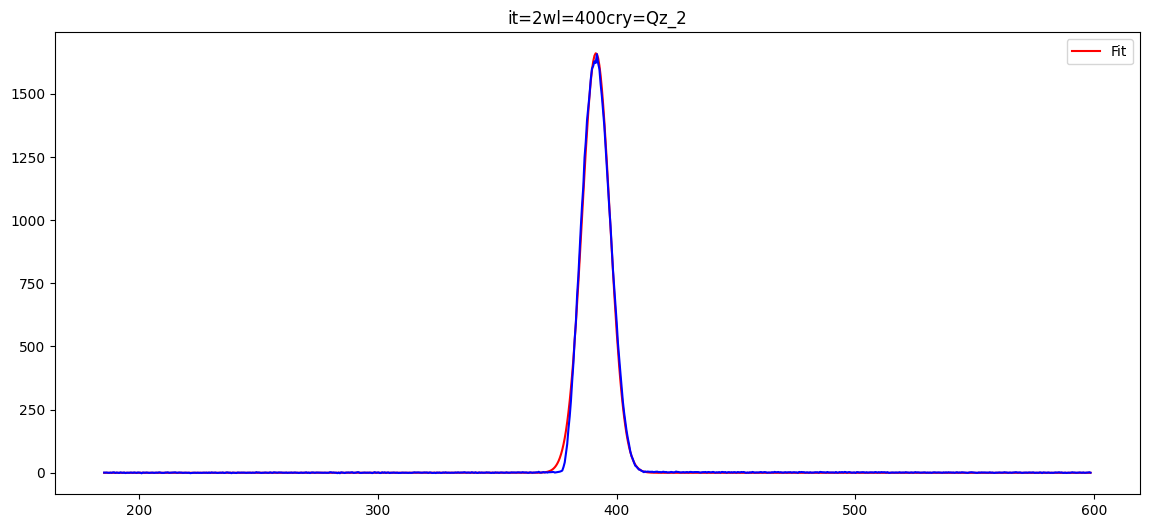

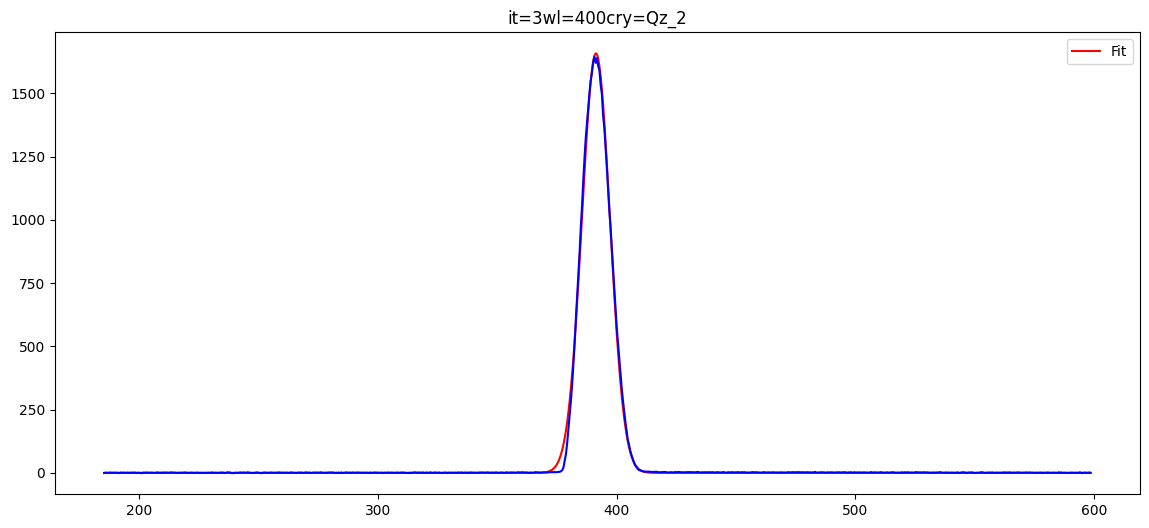

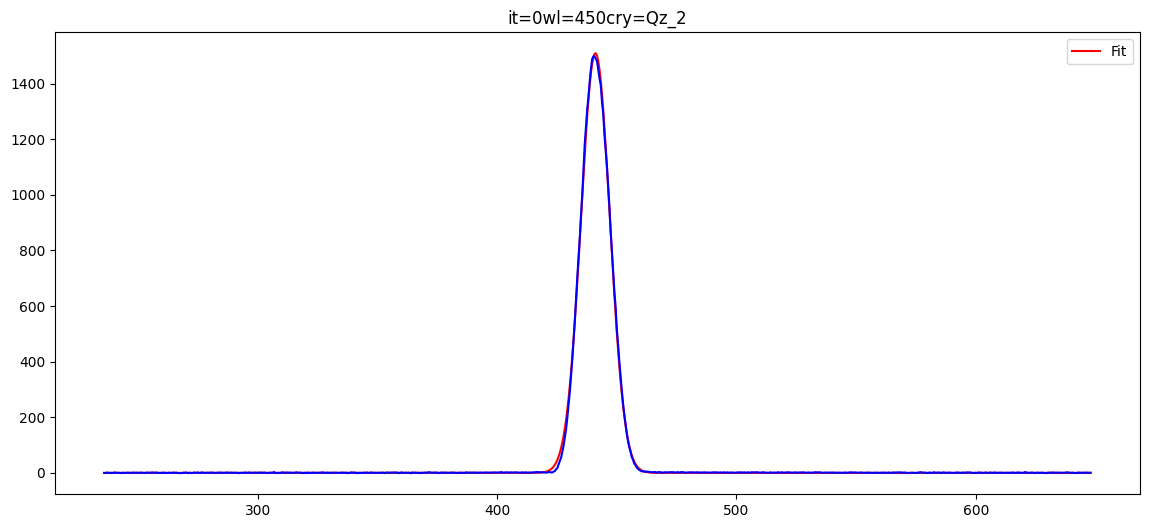

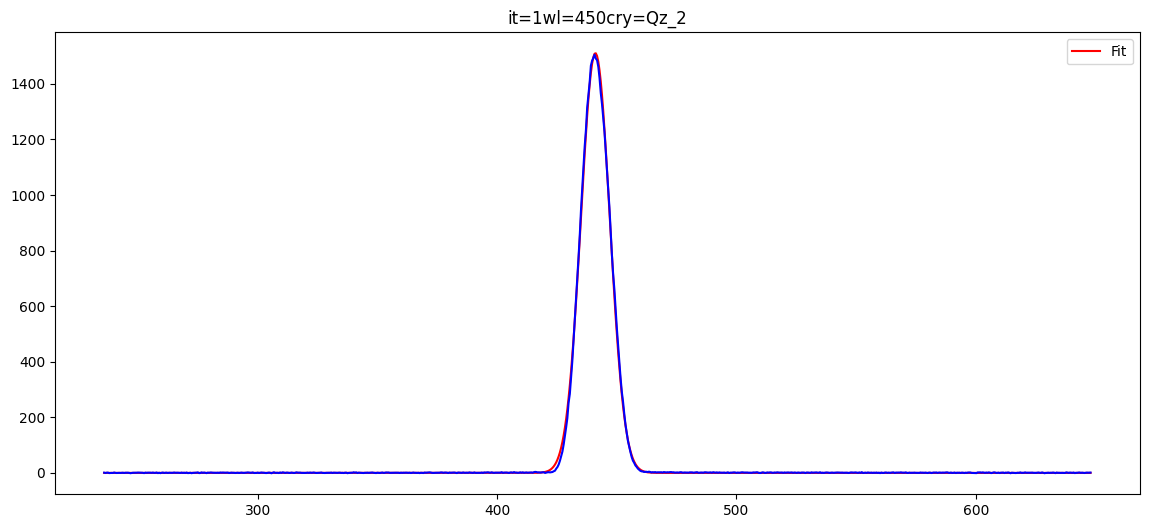

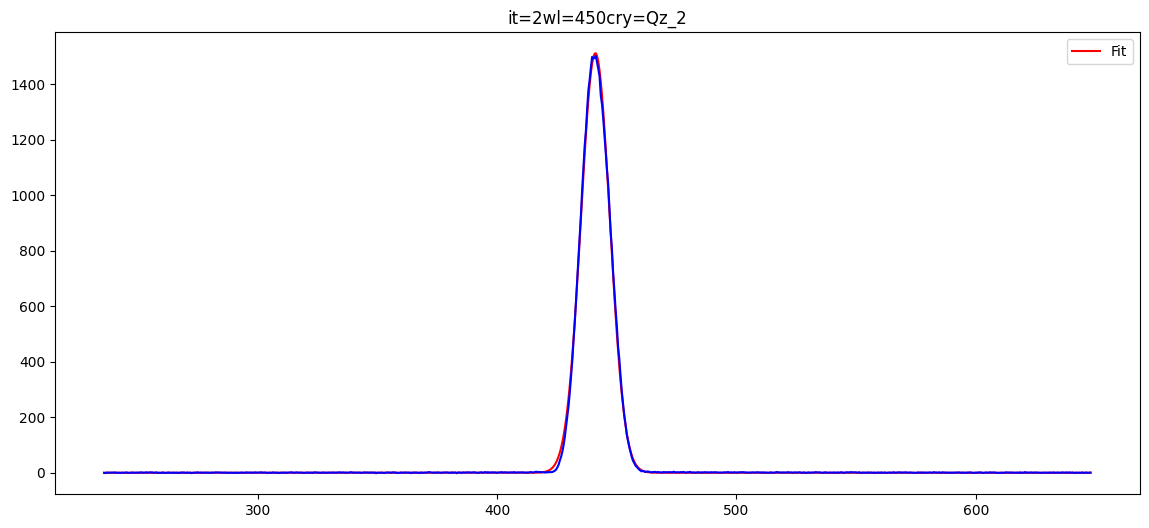

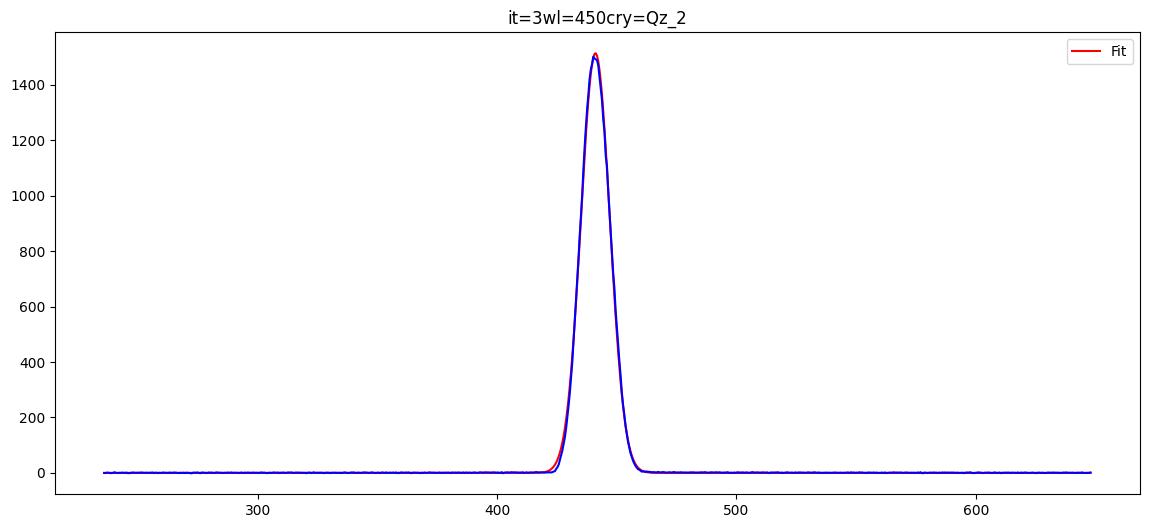

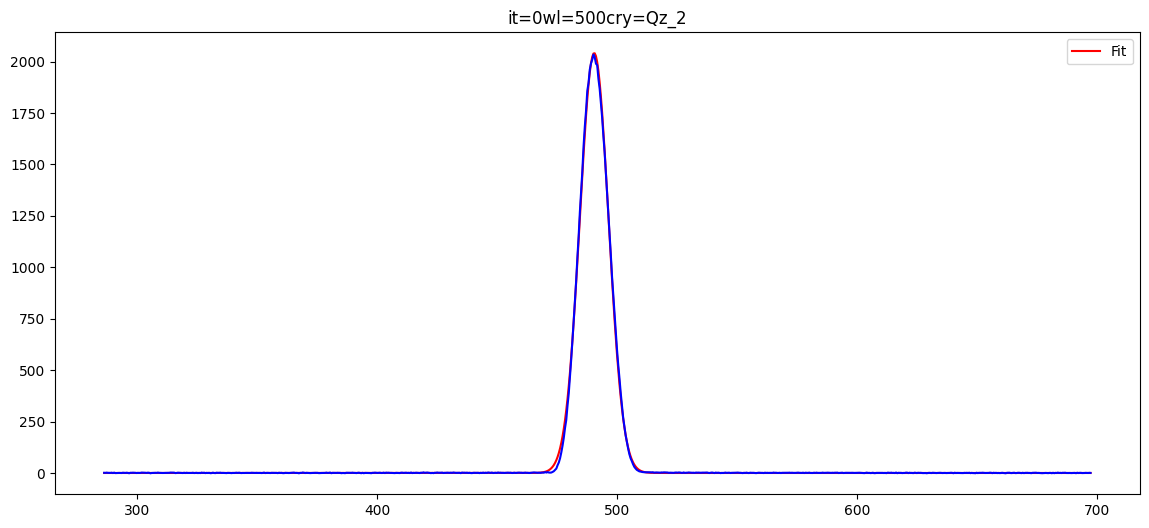

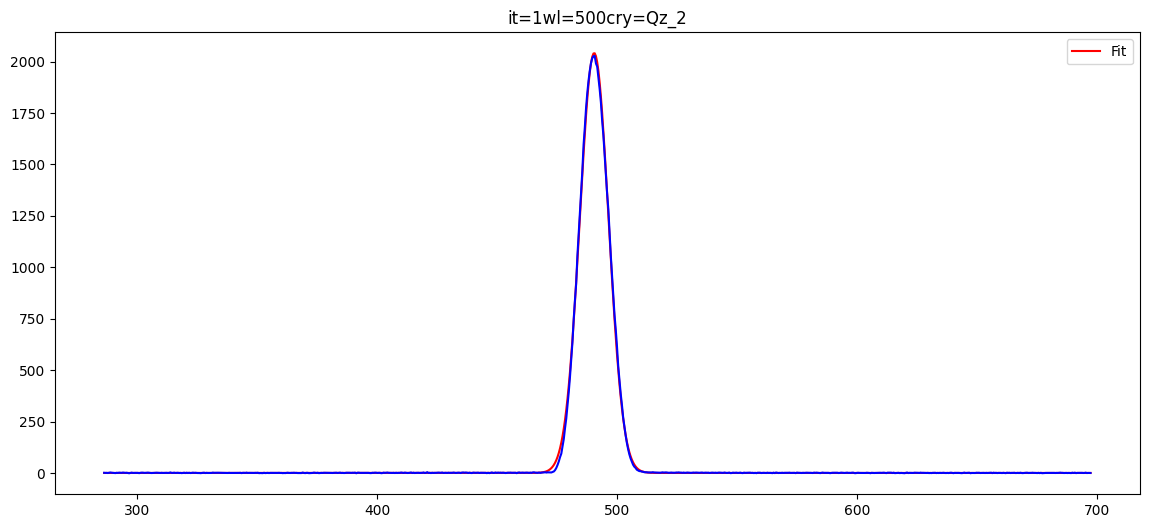

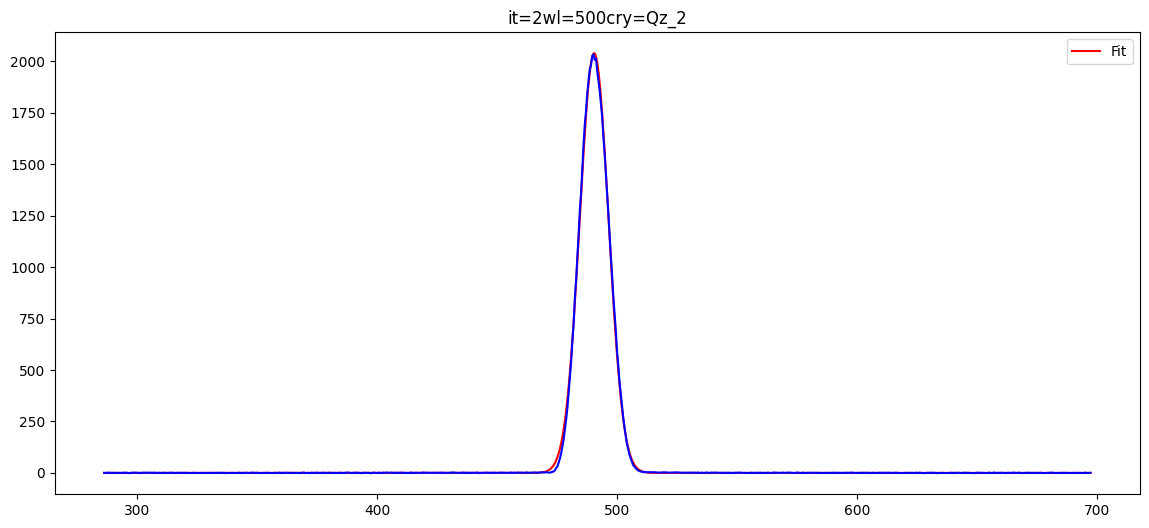

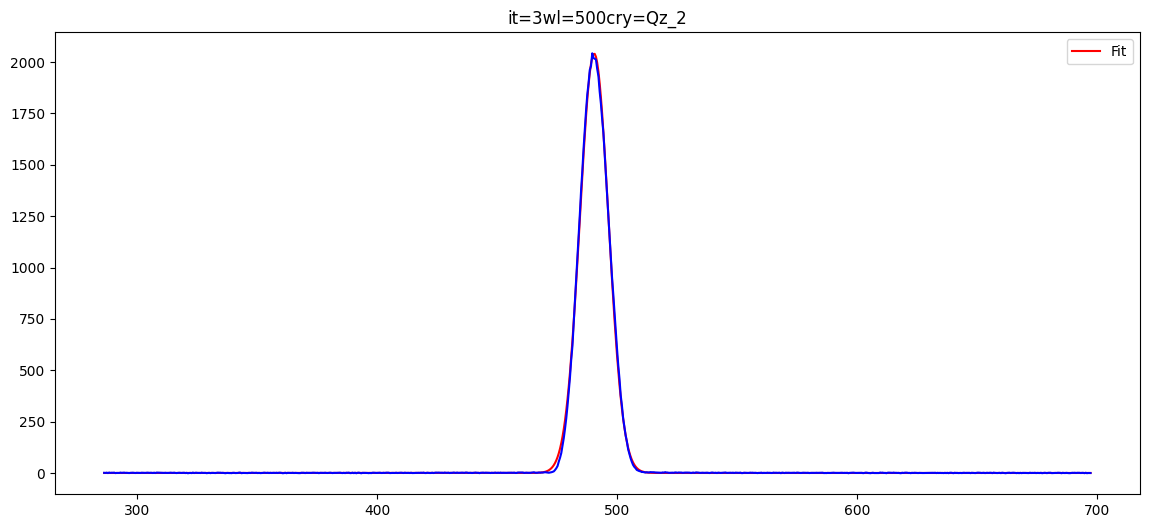

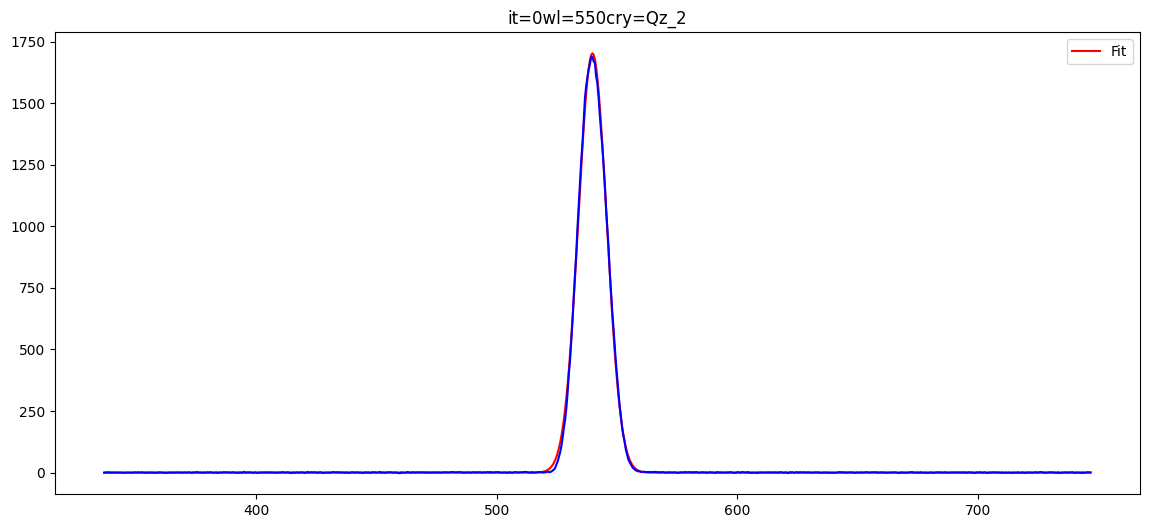

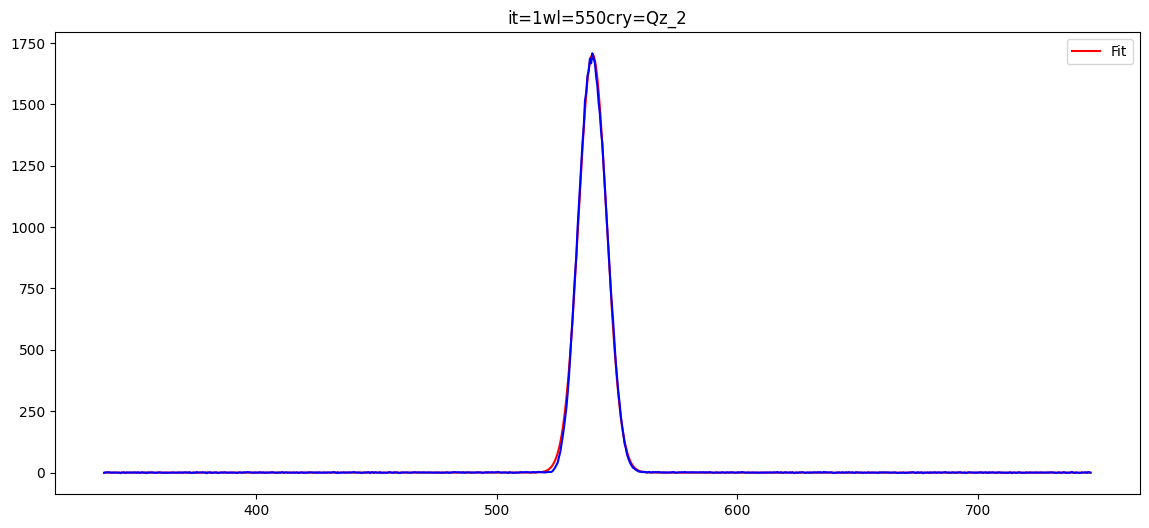

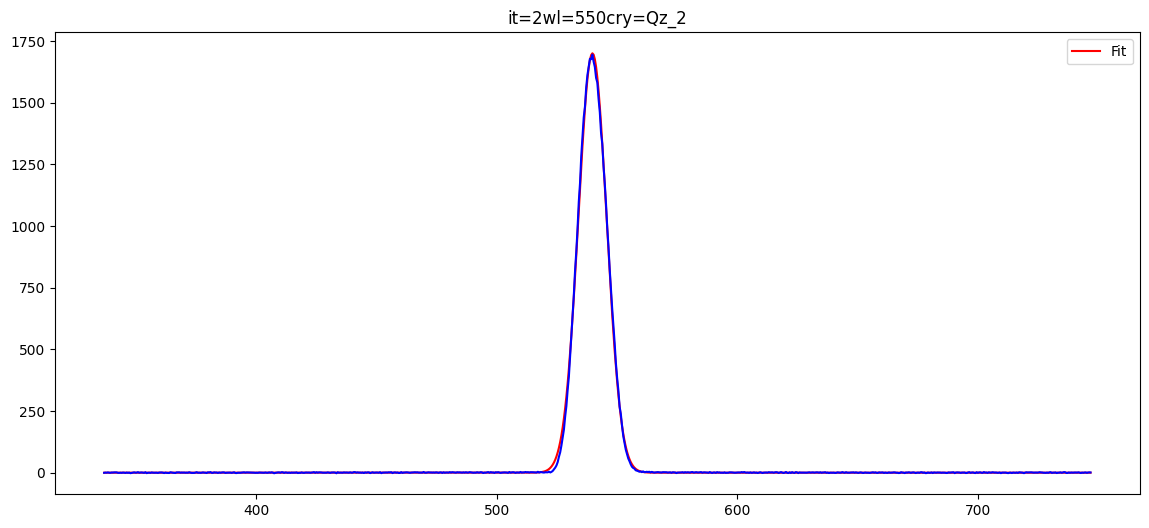

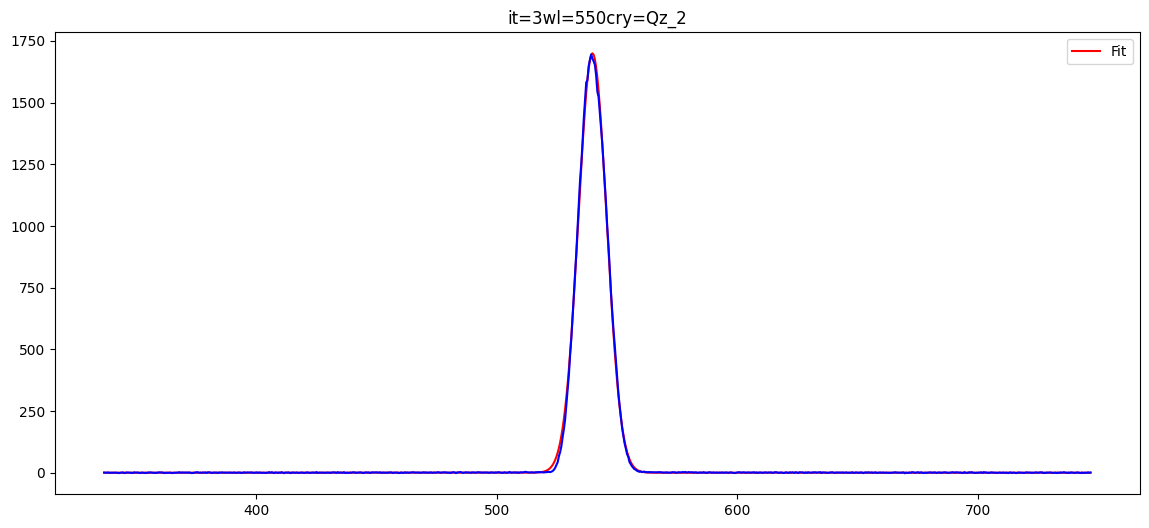

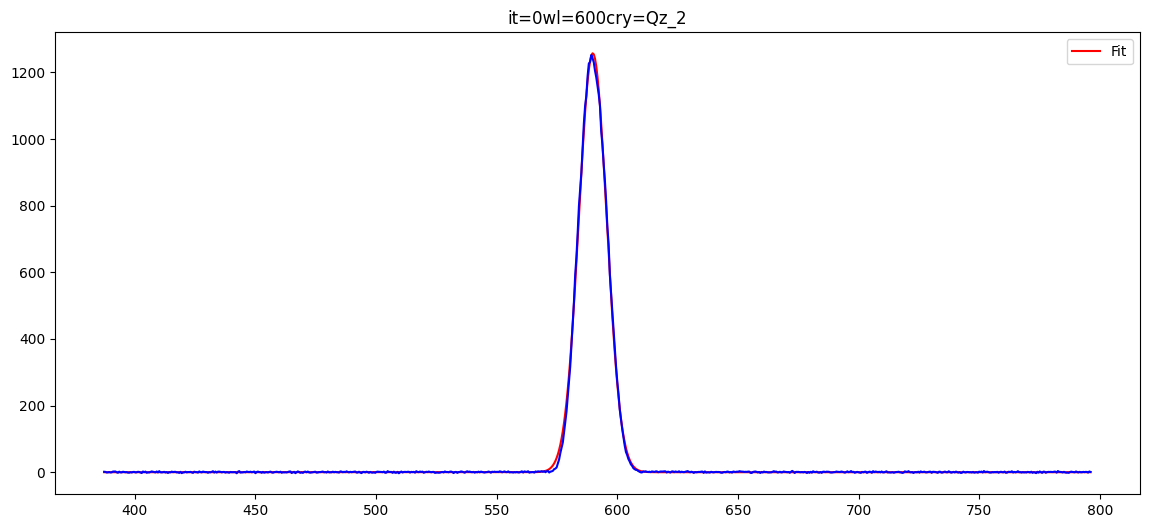

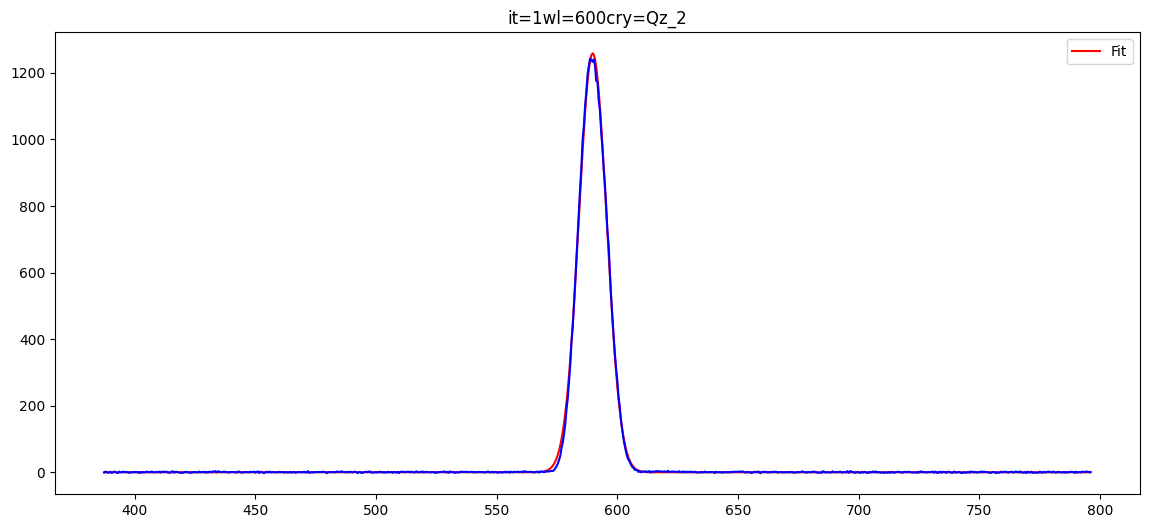

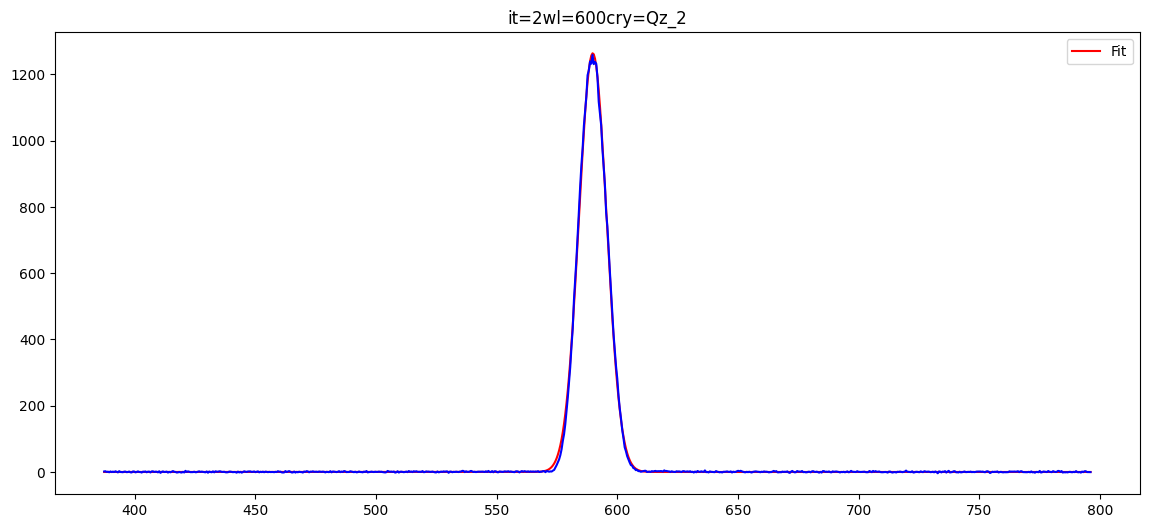

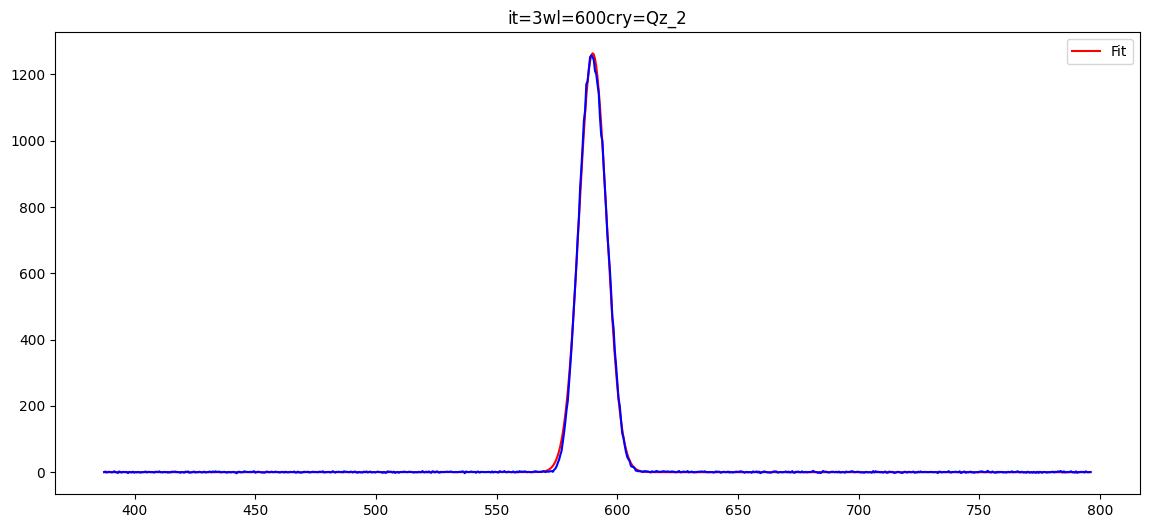

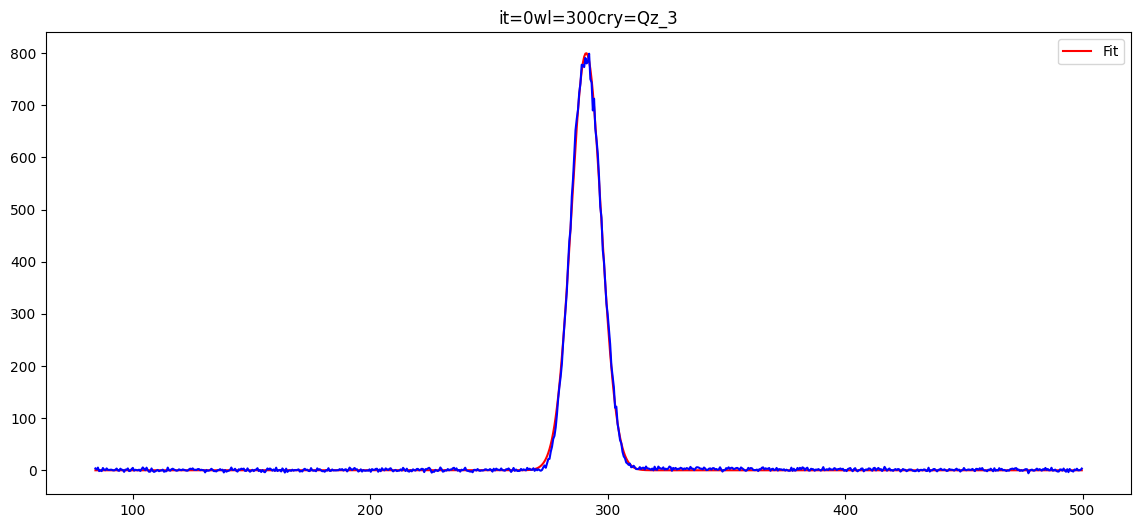

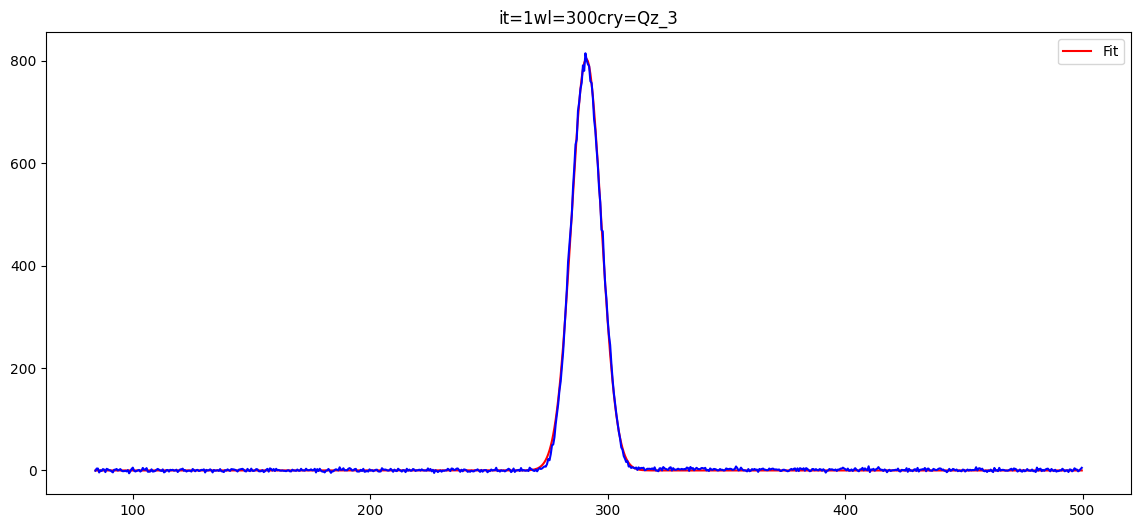

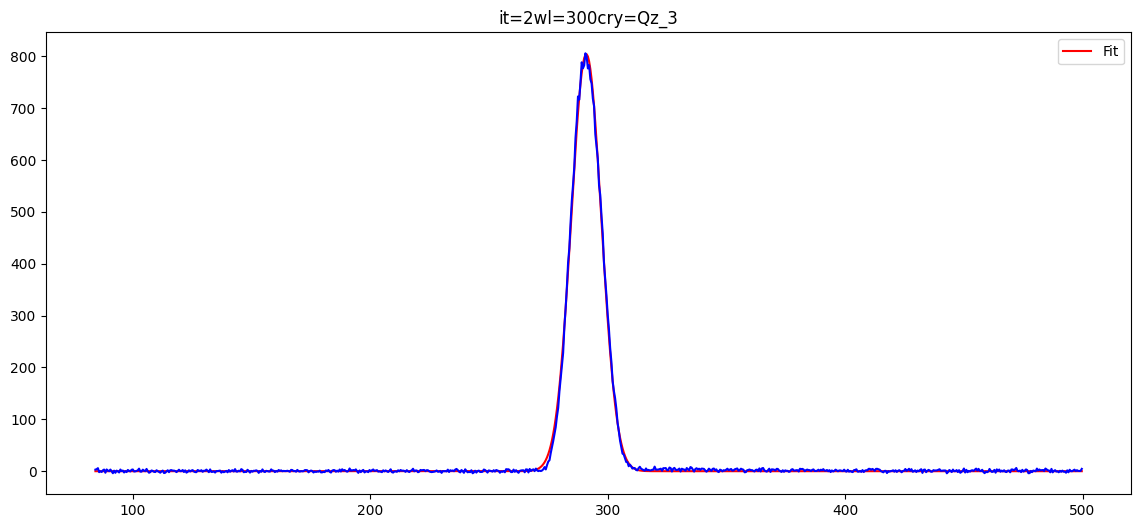

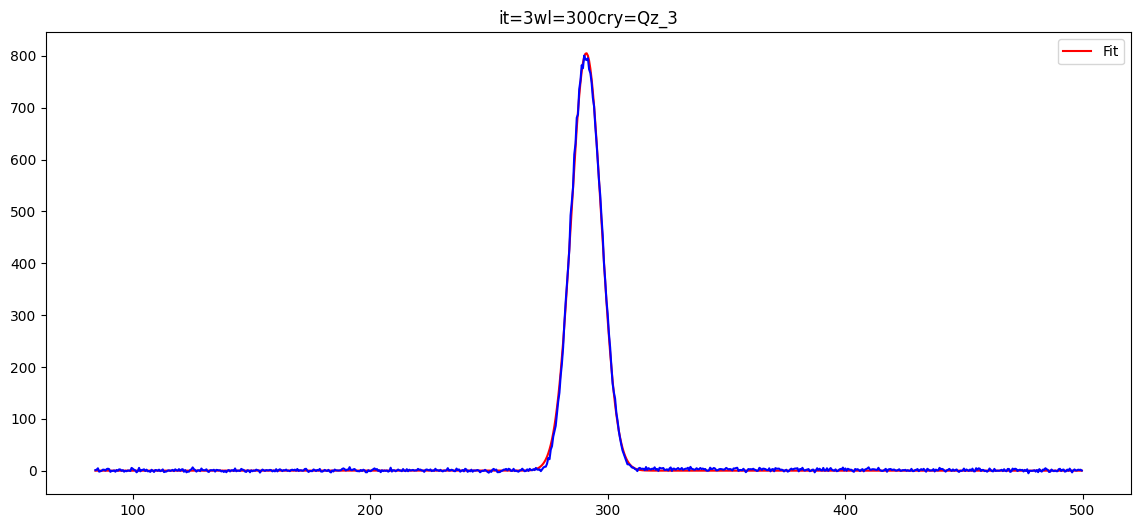

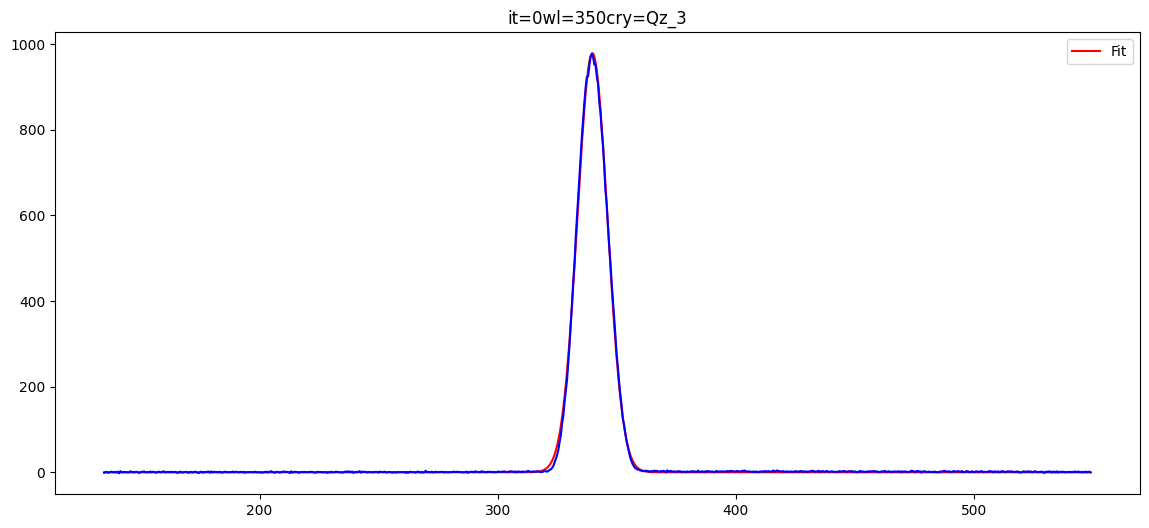

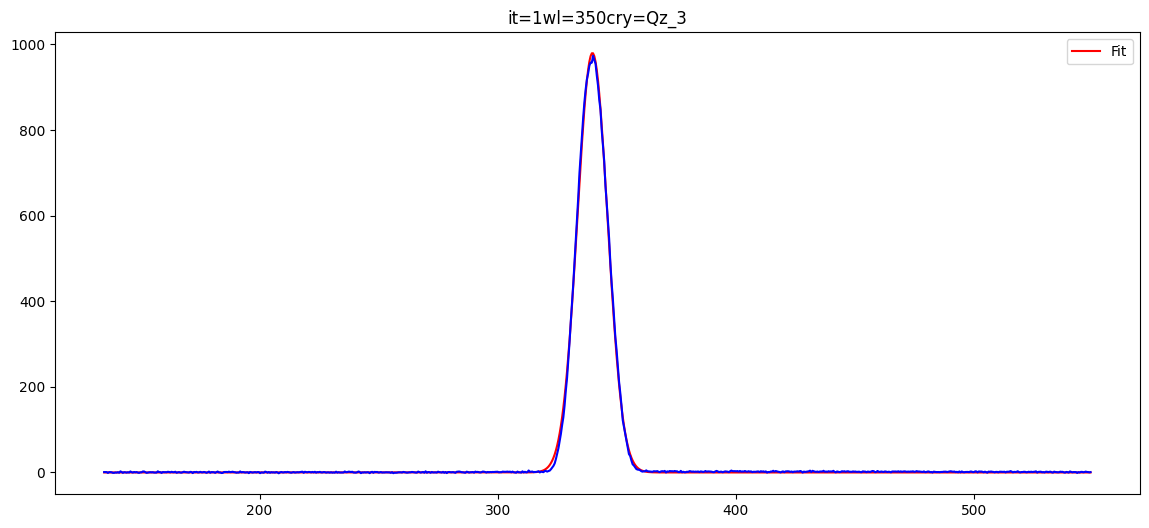

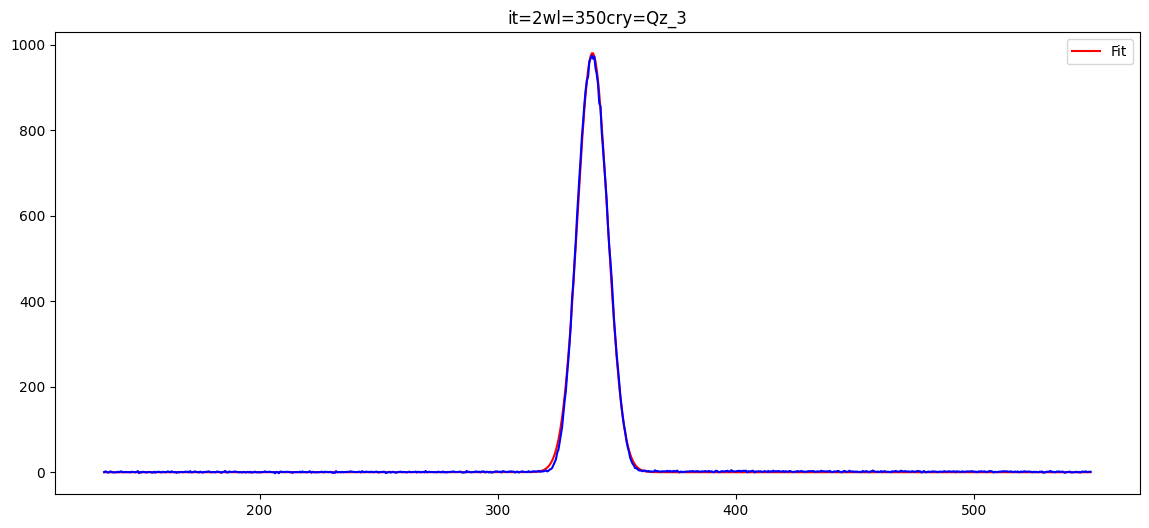

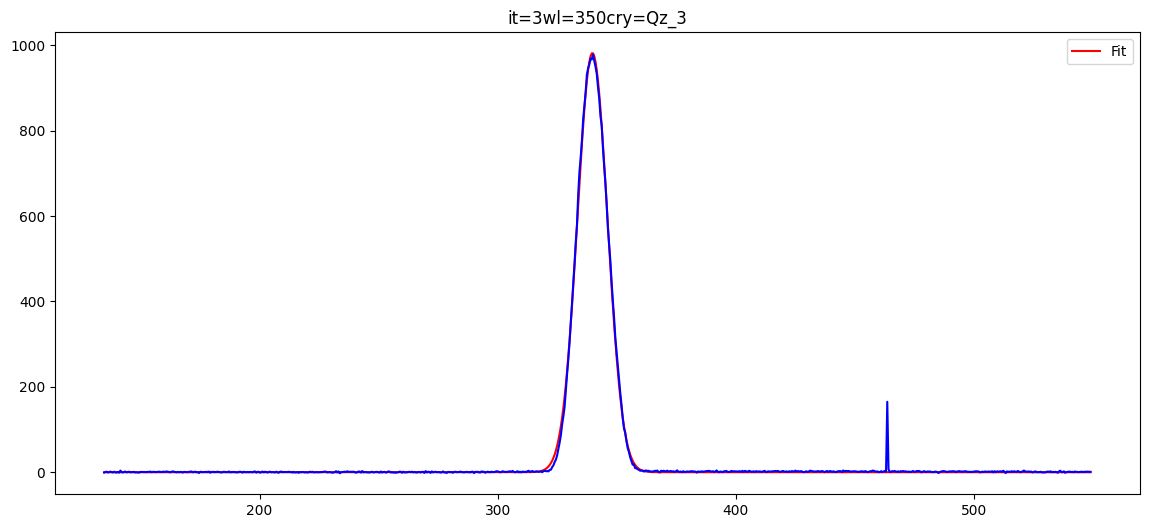

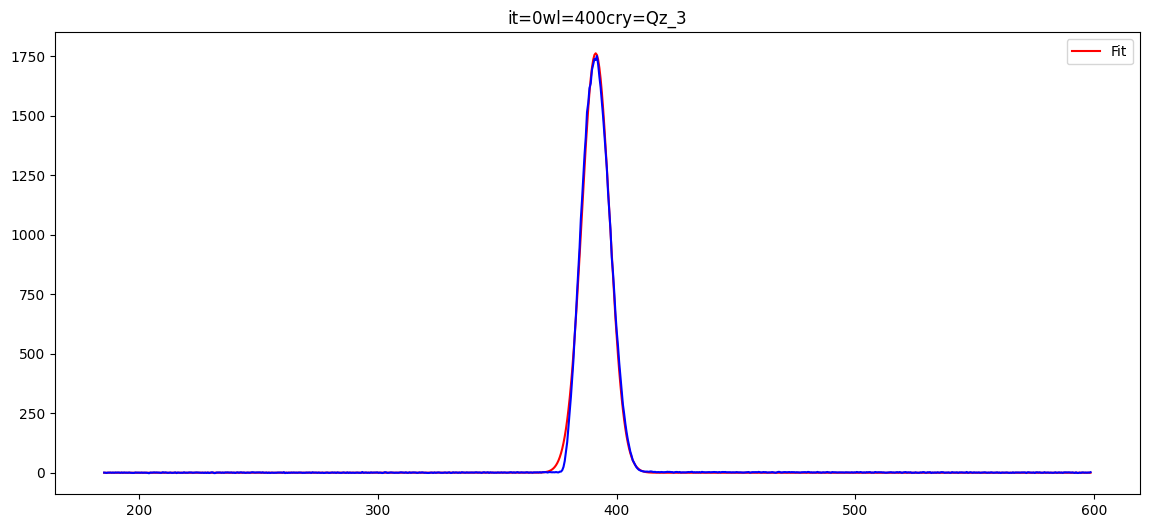

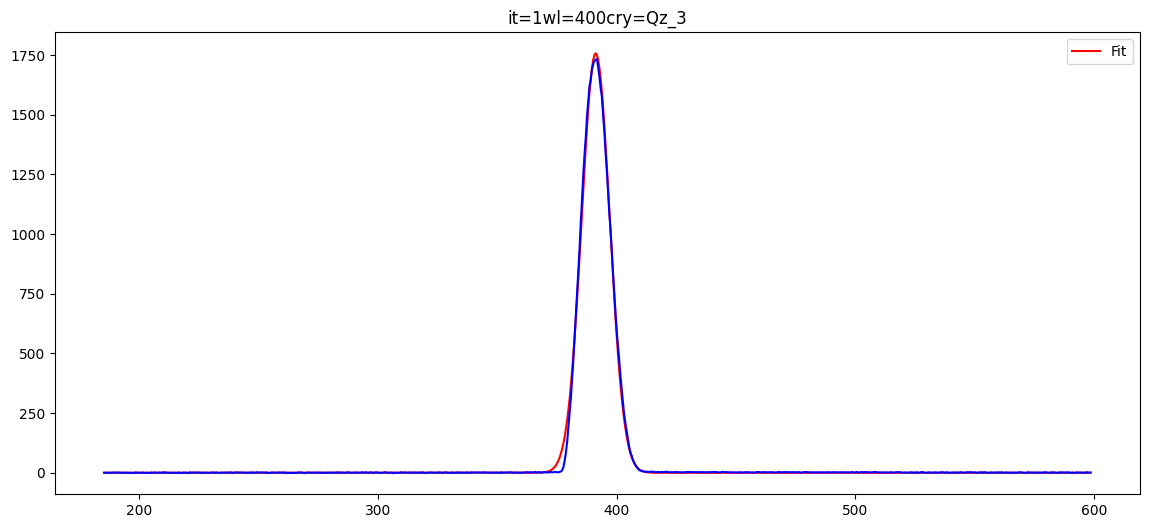

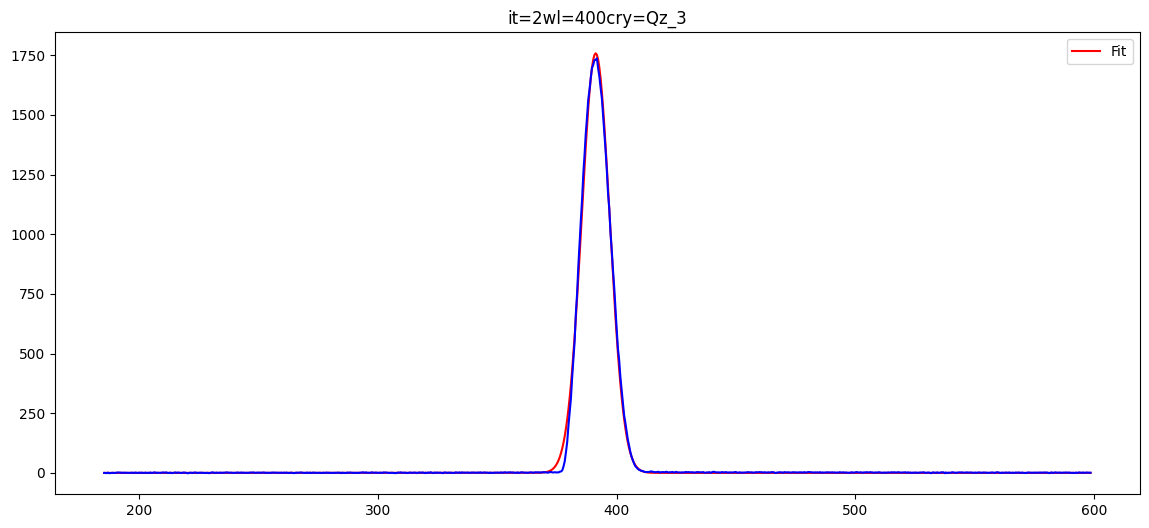

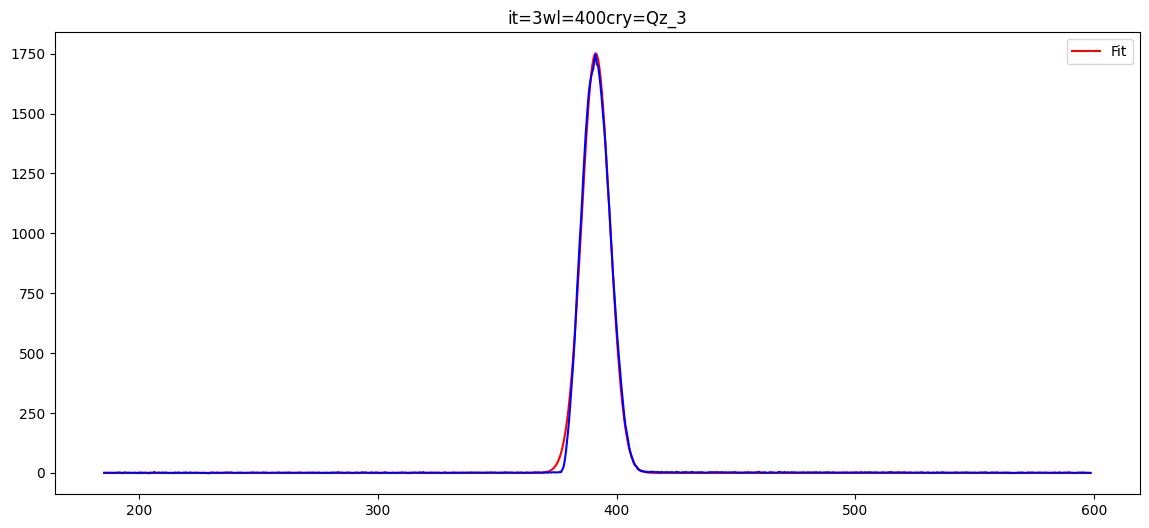

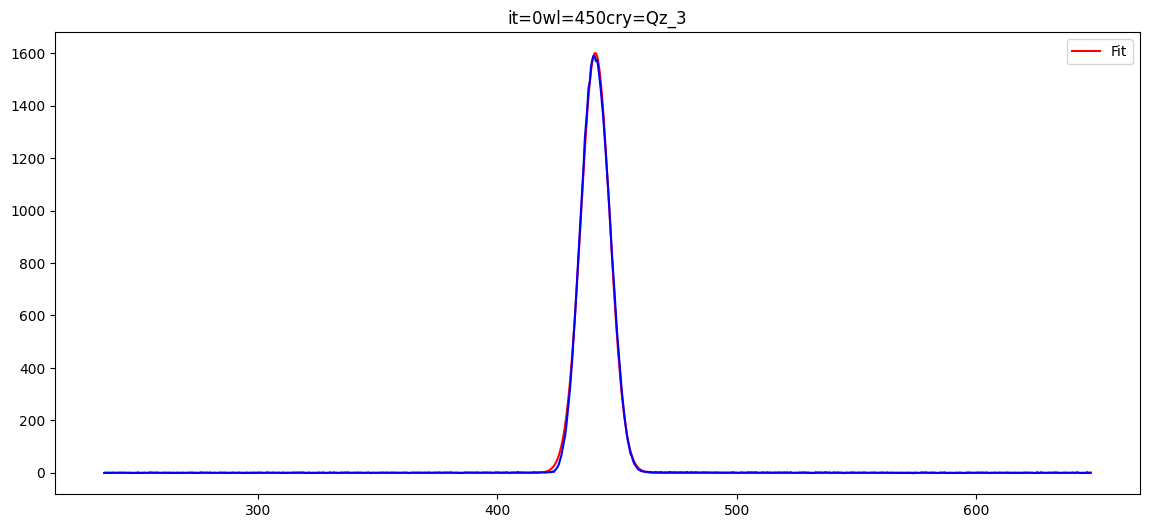

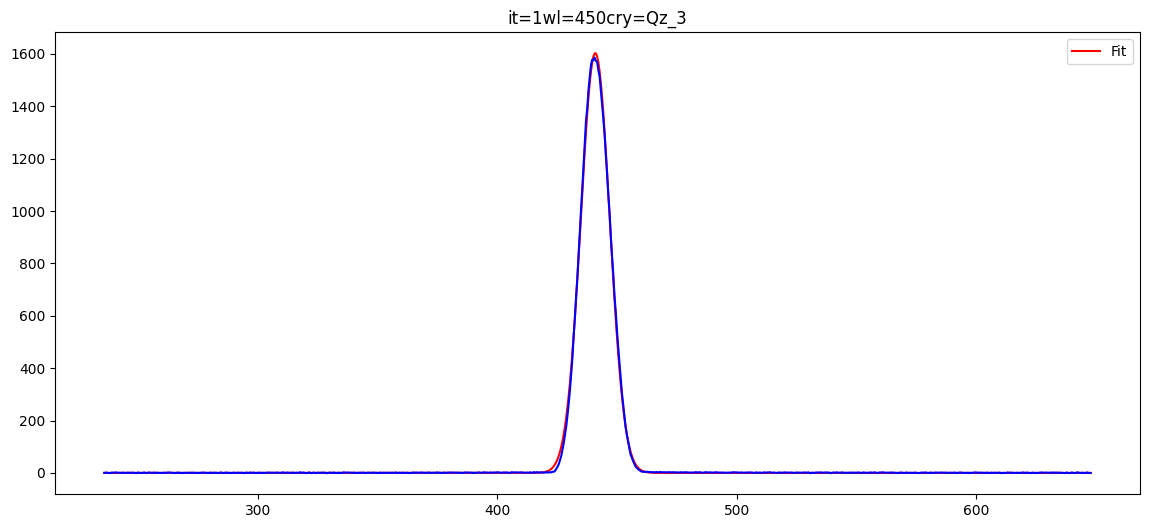

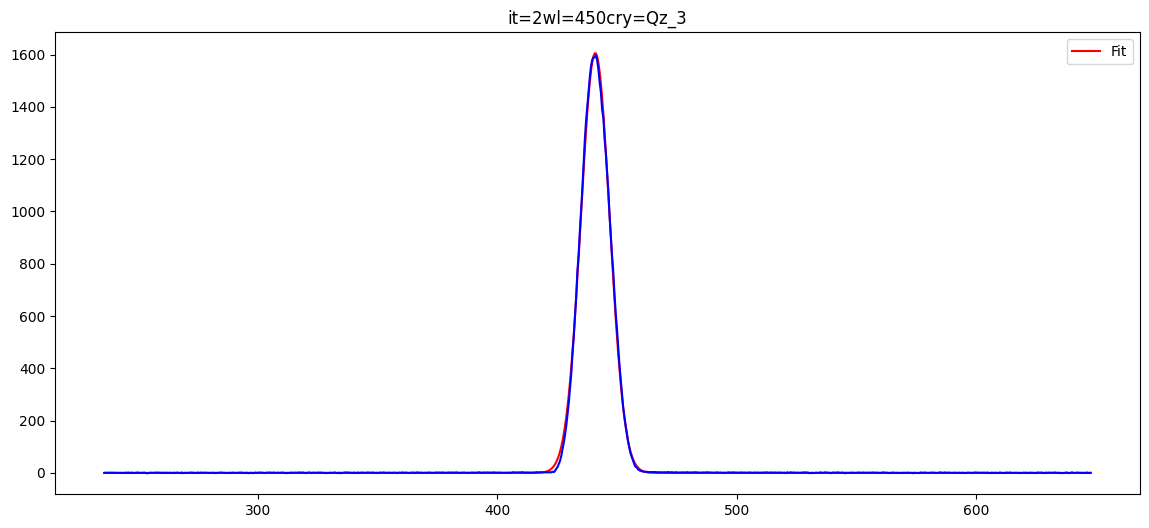

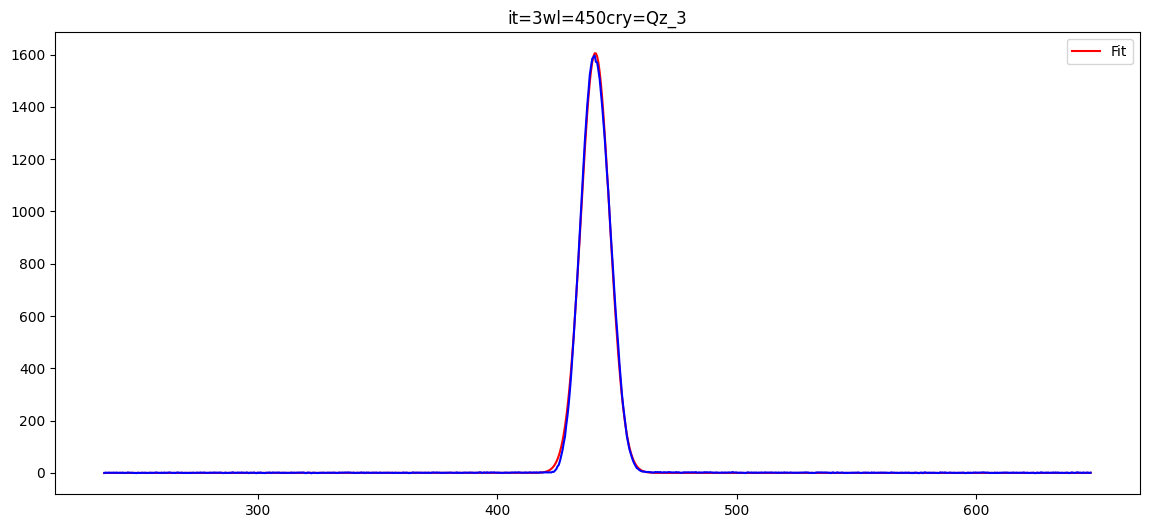

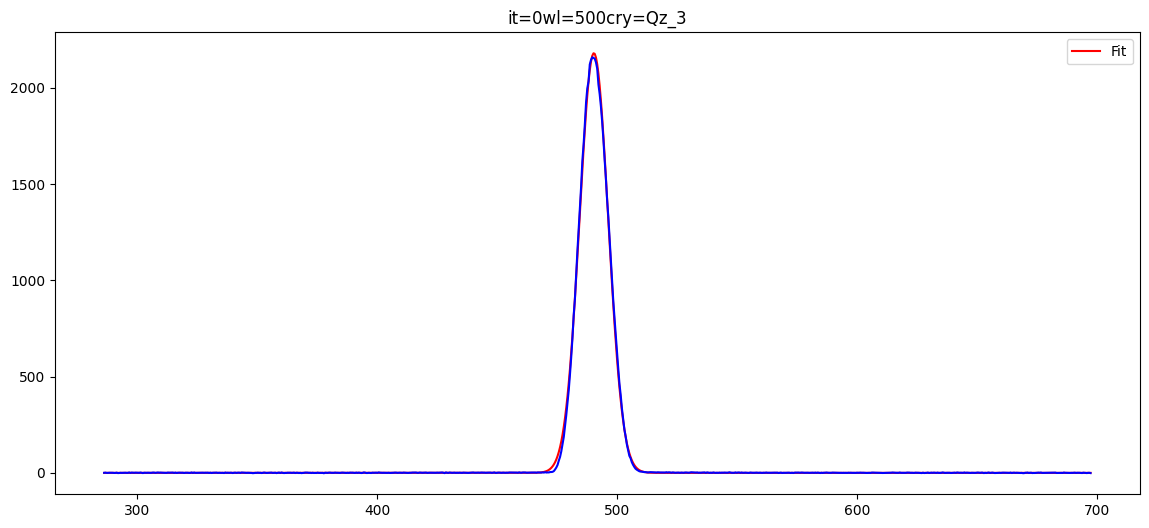

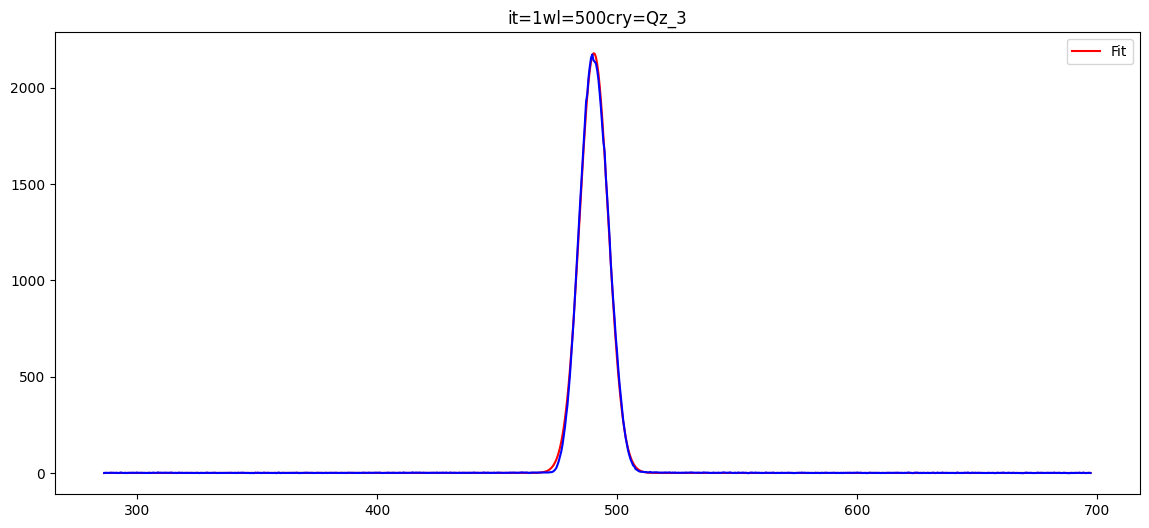

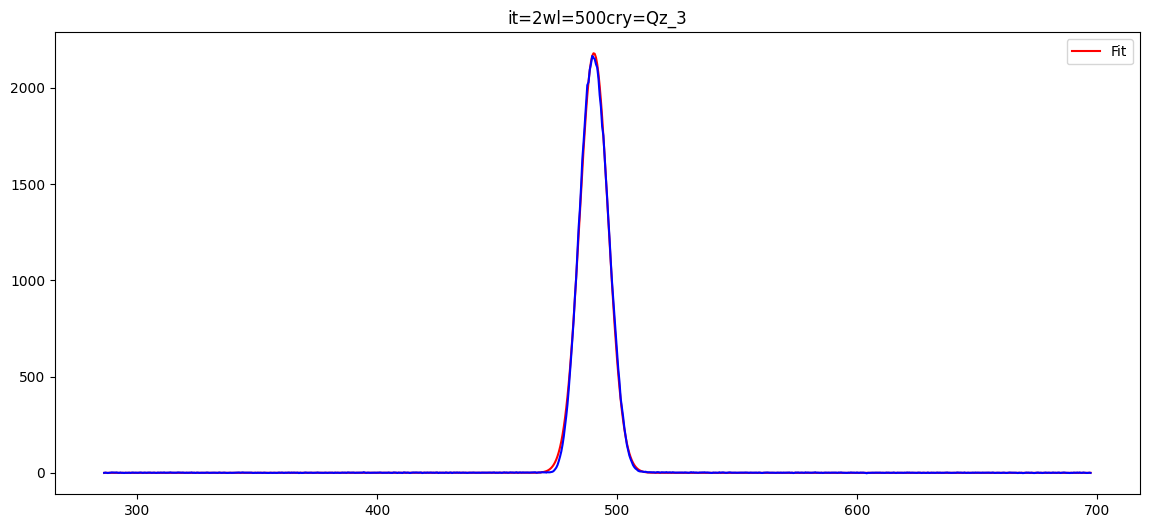

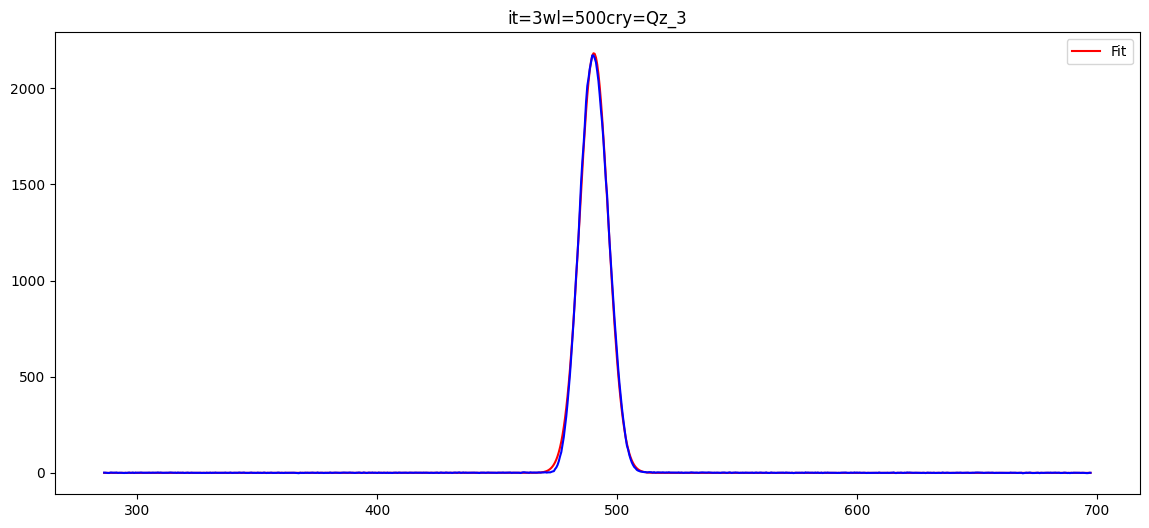

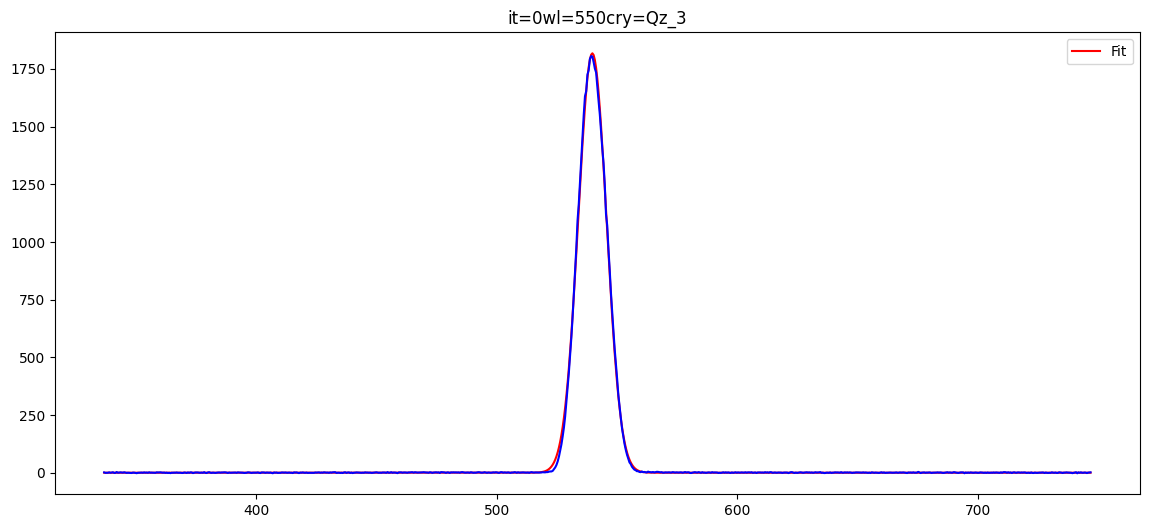

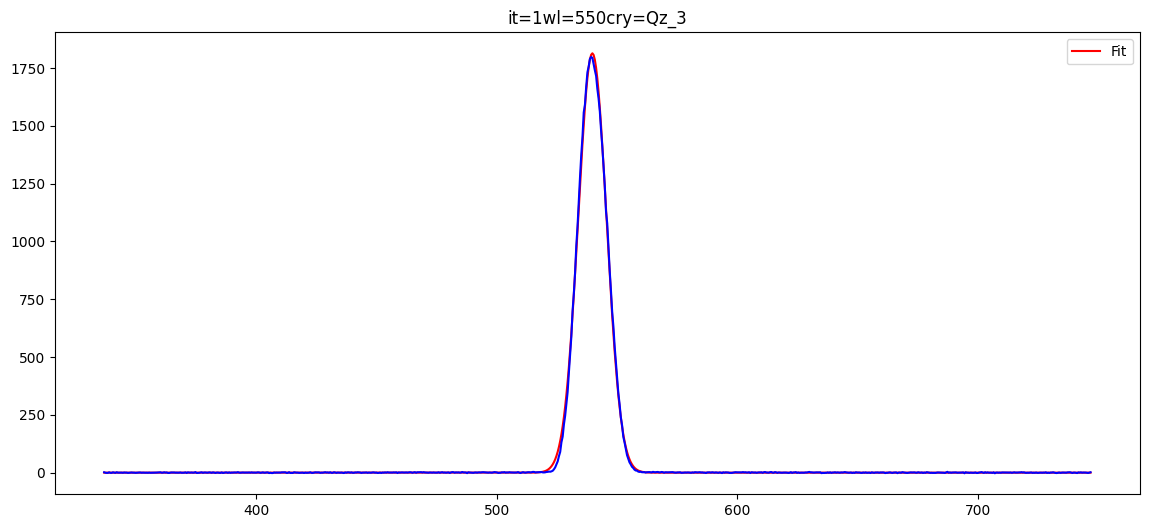

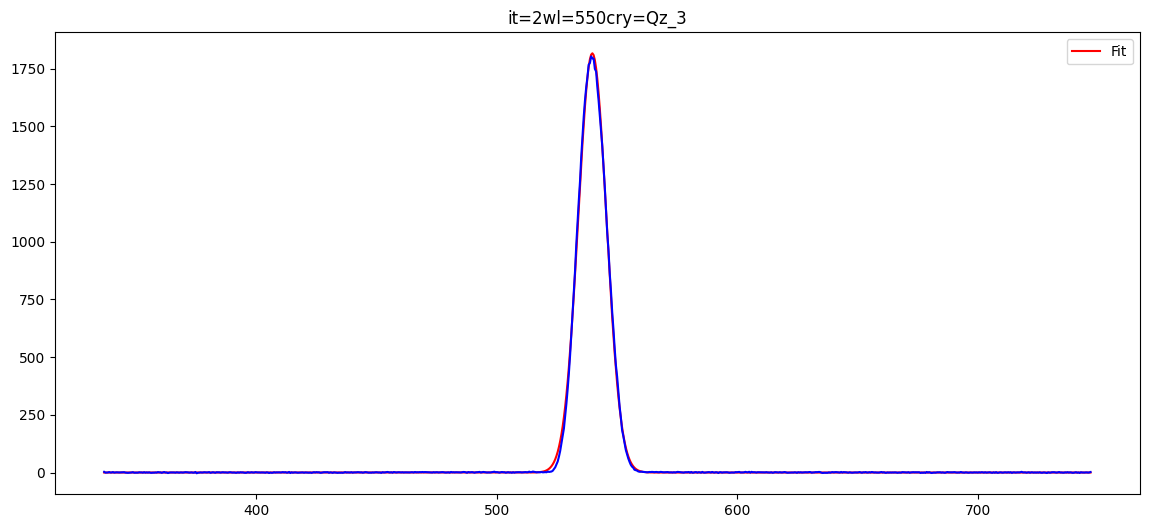

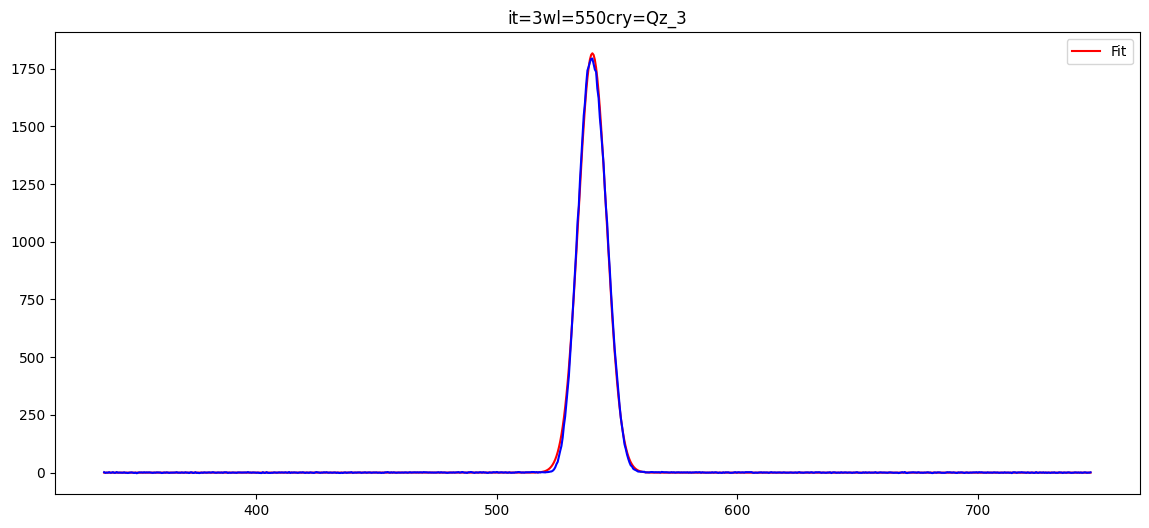

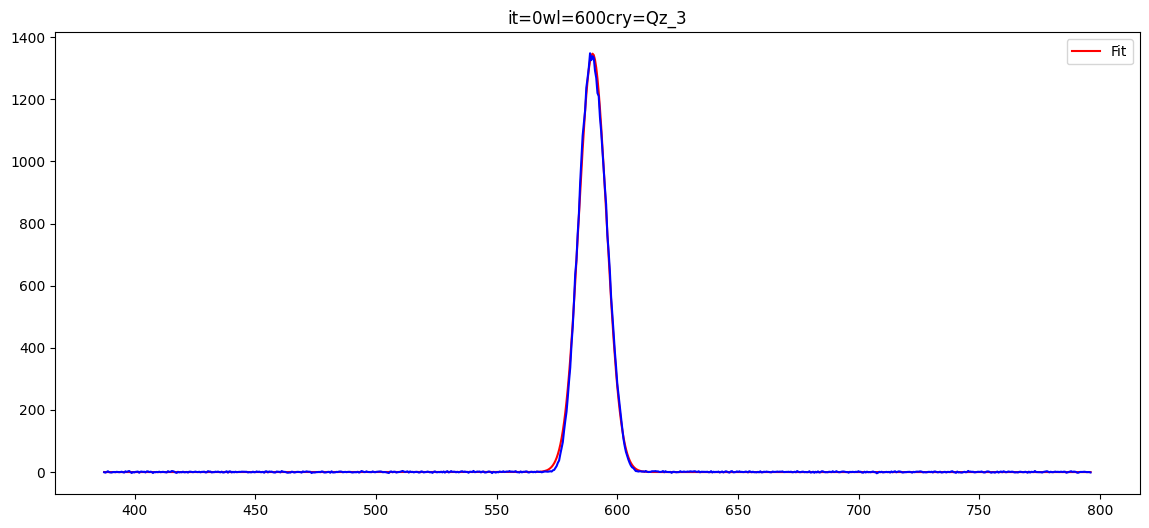

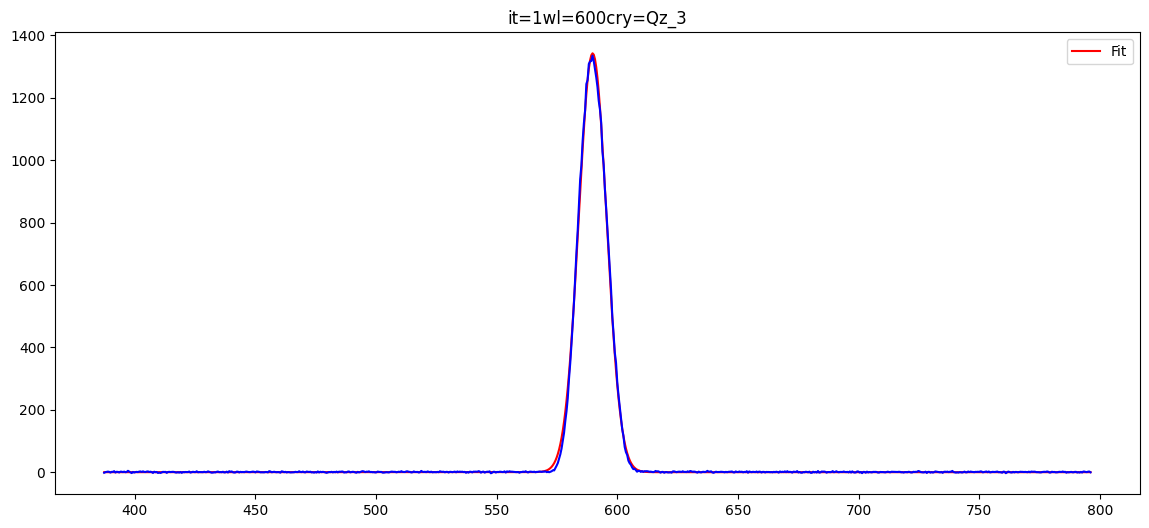

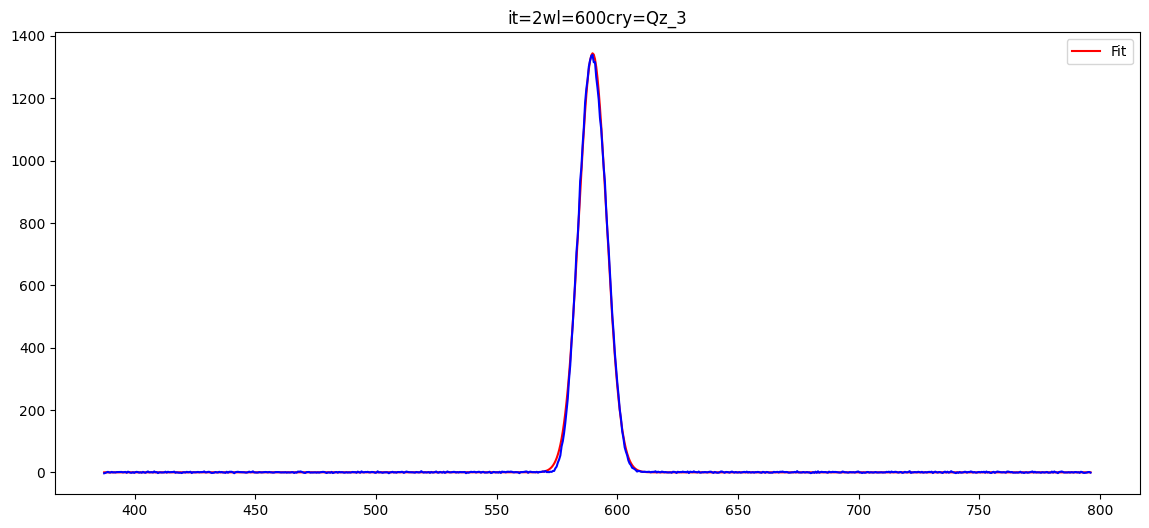

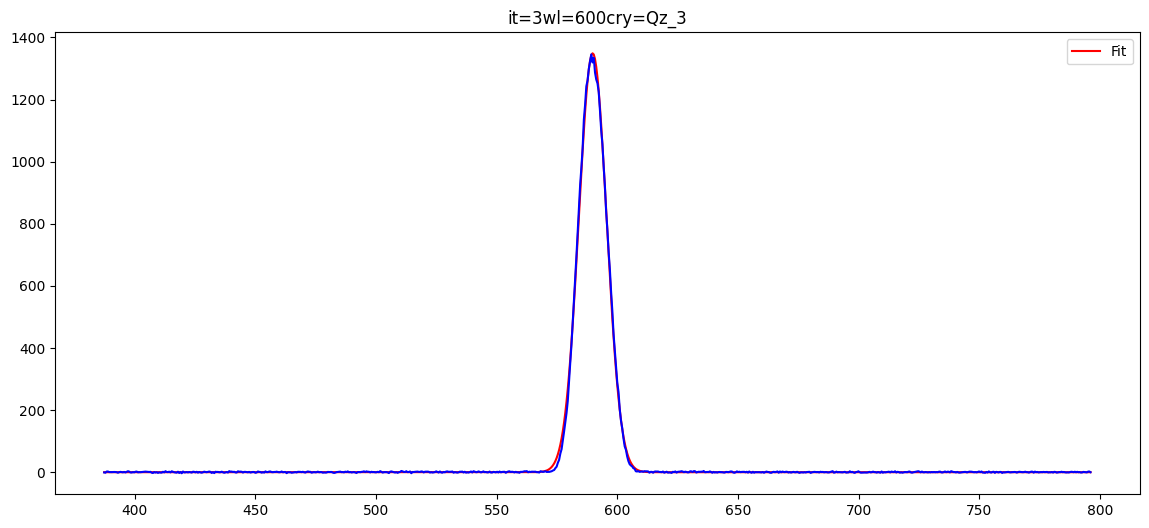

In [15]:
# Fitting to gaussian / Two Gaussians, Calculating the area under the curve & Chi_squared (goodness of fitting parameter).
# All saved in "Fitting" dictionary
def gaussian(x,m,s,A):
    return A * np.exp(-(x-m)**2/(2*s**2))
def gaussian_2 (x,m1,s1,A1,m2,s2,A2):
    return gaussian(x,m1,s1,A1)+gaussian(x,m2,s2,A2)
def Lorentzian(x,x0,gamma,A):
    return A/gamma/(1+((x-x0)/gamma)**2)
Fitting={}
# Iterate through Qtz data variables
for key,data_dict  in processed_data.items():
    Fitting[key]={}
    # Iterate through "it" values (0 to 3)
    for ex_wl,data1  in data_dict.items():
        Fitting[key][ex_wl]={}
        for it, data in data1.items():
            wl = data['wl']
            spec = data['spec']
            #popt, pcov = curve_fit(gaussian_2,wl,spec, p0=[200,50,500,200,50,500])
            popt1, pcov1 = curve_fit(gaussian,wl,spec, p0=[300,50,500])
            #ChiSq= np.sum(np.divide((spec-gaussian_2(wl, *popt))**2,gaussian_2(wl, *popt))) 
            #ChiSq1= np.sum(np.divide((spec-gaussian(wl, *popt1))**2,gaussian(wl, *popt1)))
            Area= (np.sum(np.delete(spec, -1)*np.diff(wl))+np.sum(np.delete(spec, 0)*np.diff(wl)))/2
            Fitting[key][ex_wl][it]={'popt':popt1, 'pcov':pcov1,'area':Area}
            plt.figure()
            #plt.plot(wl, gaussian_2(wl, *popt),label='Fit',color='orange')
            plt.plot(wl, gaussian(wl, *popt1),color='r',label='Fit')
            plt.legend()
            plt.plot(wl,spec,color='blue')
            #plt.text(500,1000,f'ChiSq={ChiSq}')
            #plt.text(600,2500,f'ChiSq1={ChiSq1}')
            plt.title(f'it={it}wl={ex_wl}cry={key}')
            plt.show()
            #plotting the components of the signal 
        #plt.plot(wl,gaussian(wl,*popt[0:3]),'--r')
        #plt.plot(wl,gaussian(wl,*popt[3:6]),'--y')
        

In [16]:
# Creating a Dictionary containing the paramets as a vector (it0,it1,it2,it3) for each Crystal called "fit_Parameters"
# It also cotaines averages and std of the parameters vectors.
fit_parameters={}
for key,item in Fitting.items():
    fit_parameters[key]={}
    for ex_wl,data in item.items():
        M=[]
        S=[]
        A=[]
        Areas=[]
        
        fit_parameters[key][ex_wl]={}
        for it, data1 in data.items():
            
            M.append(data1['popt'][0])
            S.append(data1['popt'][1])
            A.append(data1['popt'][2])
            Areas.append(data1['area'])
        fit_parameters[key][ex_wl]={'M':np.array(M),'av_M':np.mean(M),'std_M':np.std(M),
                        'S':np.array(S),'av_S':np.mean(S),'std_S':np.std(S),
                        'A':np.array(A),'av_A':np.mean(A),'std_A':np.std(A),
                        'Areas':Areas, 'av_Areas':np.mean(Areas),'std_Areas':np.std(Areas)}

In [17]:
fit_parameters

{'Qz_1': {300: {'M': array([291.01009453, 291.0040916 , 291.00417521, 291.02137951]),
   'av_M': 291.0099352127581,
   'std_M': 0.007041356935982331,
   'S': array([6.29787107, 6.32860138, 6.3325719 , 6.32013748]),
   'av_S': 6.319795458111017,
   'std_S': 0.013431095610250054,
   'A': array([739.71842646, 735.92659292, 732.74489699, 736.3267976 ]),
   'av_A': 736.1791784921622,
   'std_A': 2.470129372577617,
   'Areas': [11943.89203587361,
    11980.922663717036,
    11969.00105959878,
    11926.64304438715],
   'av_Areas': 11955.114700894144,
   'std_Areas': 21.18646583055408},
  350: {'M': array([340.33037347, 340.3031131 , 340.30860125, 340.30423464]),
   'av_M': 340.3115806151762,
   'std_M': 0.011042080632240013,
   'S': array([-6.29337042, -6.30608206, -6.30031358, -6.32510863]),
   'av_S': -6.3062186706255945,
   'std_S': 0.011798269820893286,
   'A': array([913.22415721, 916.55720755, 915.18090588, 910.43525485]),
   'av_A': 913.8493813718832,
   'std_A': 2.299589383129219,
  

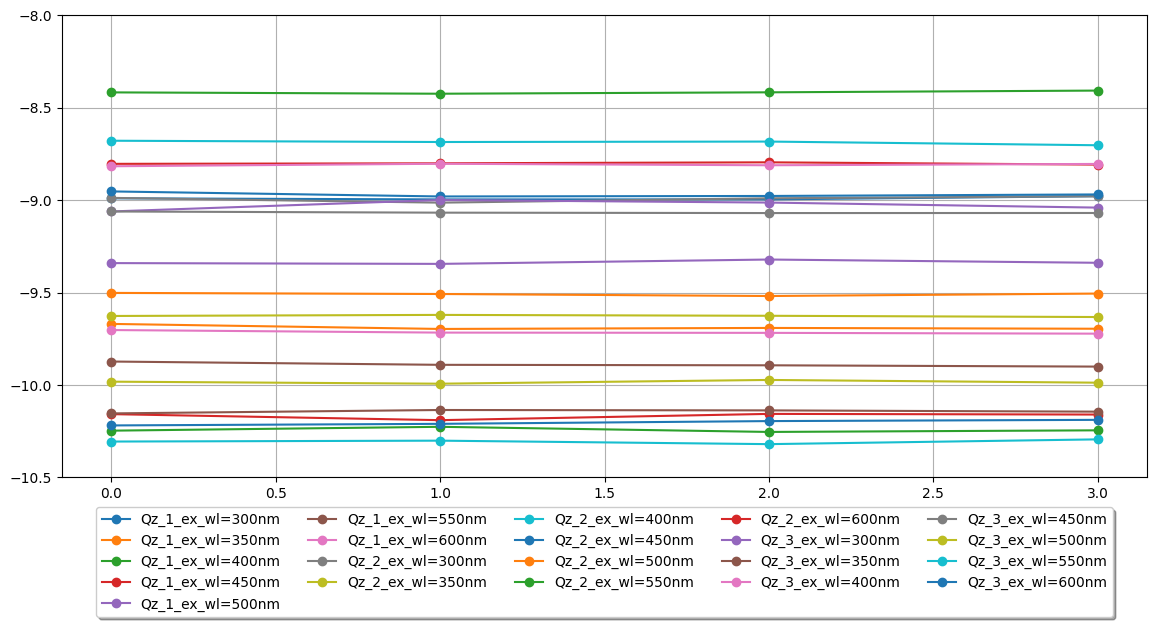

In [18]:
for key,item in fit_parameters.items():
    for ex_wl,data in item.items():
        plt.plot([0,1,2,3],data['M']-ex_wl,label=f'{key}_ex_wl={ex_wl}nm',marker='o')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
        plt.ylim(-10.5,-8)
        plt.grid()

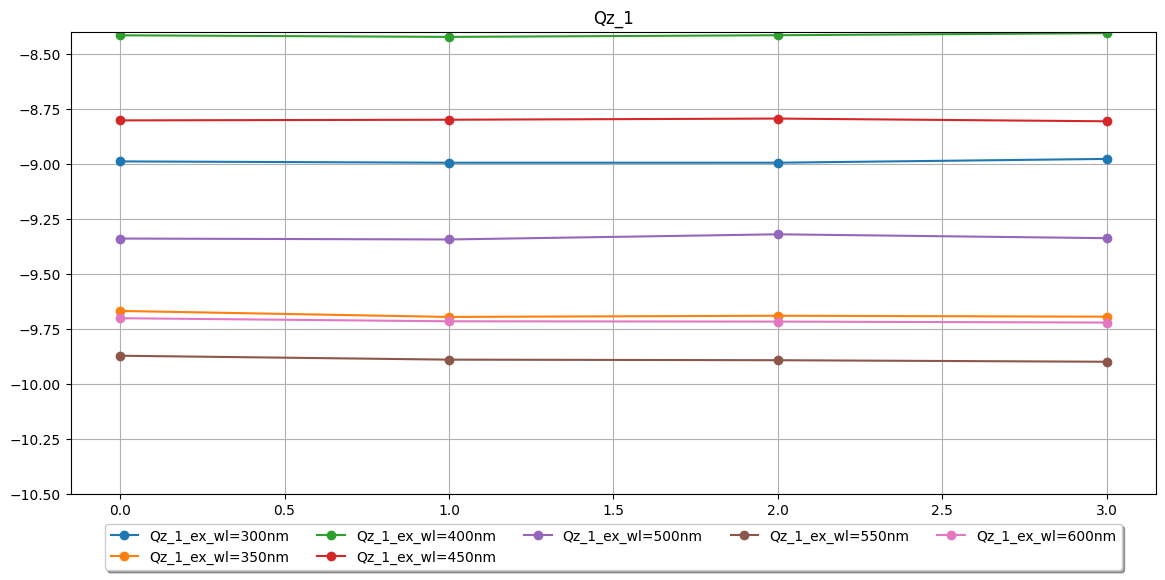

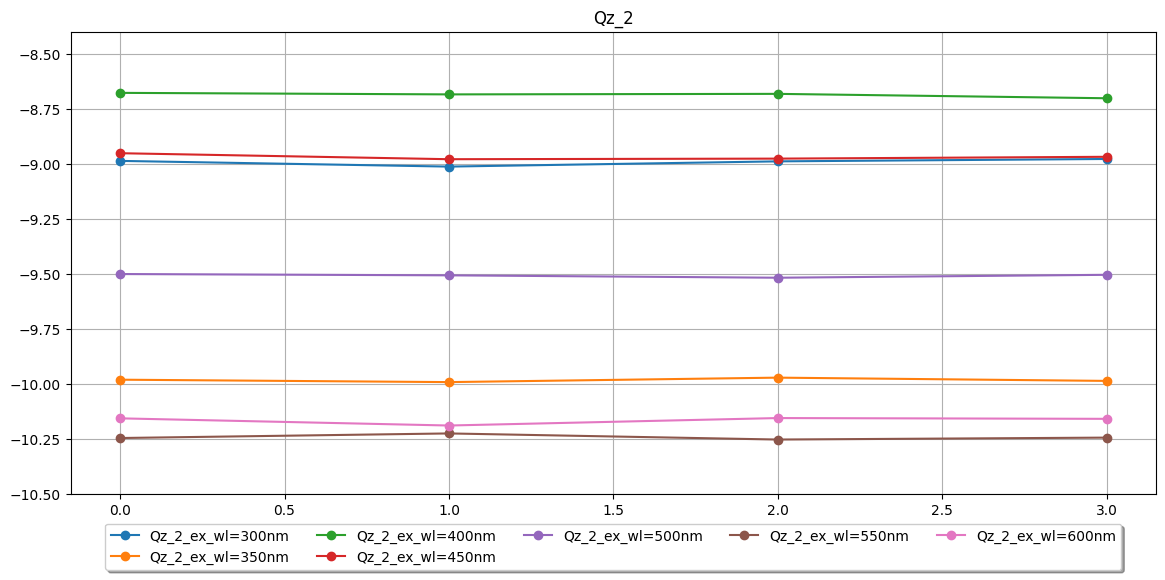

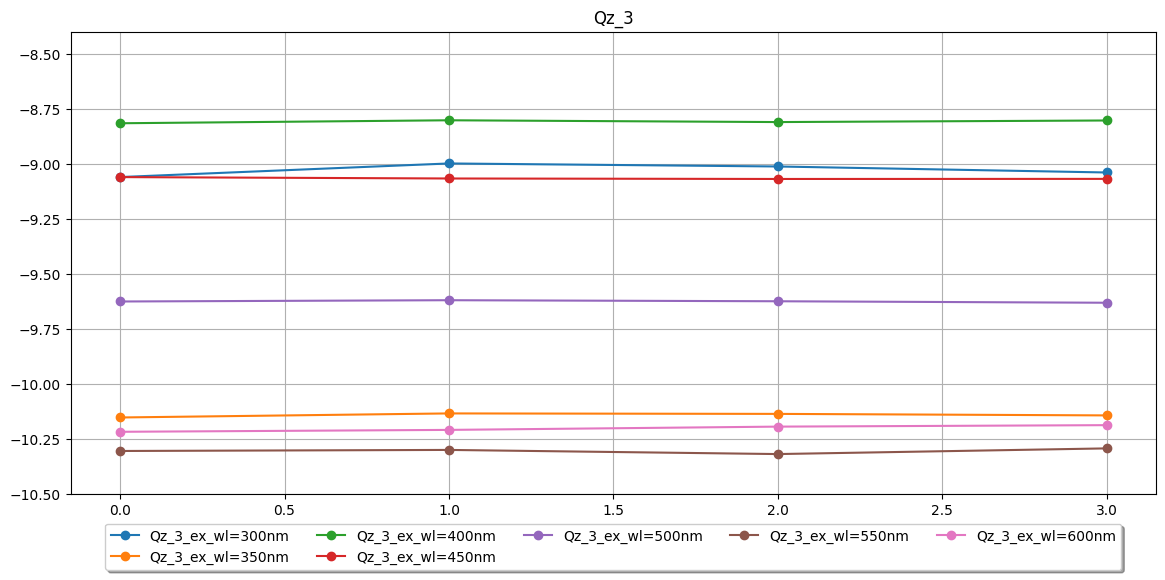

In [19]:
for key,item in fit_parameters.items():
    plt.figure()
    plt.title(f'{key}')
    for ex_wl,data in item.items():
        plt.plot([0,1,2,3],data['M']-ex_wl,label=f'{key}_ex_wl={ex_wl}nm',marker='o')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
        plt.ylim(-10.5,-8.4)
        plt.grid()

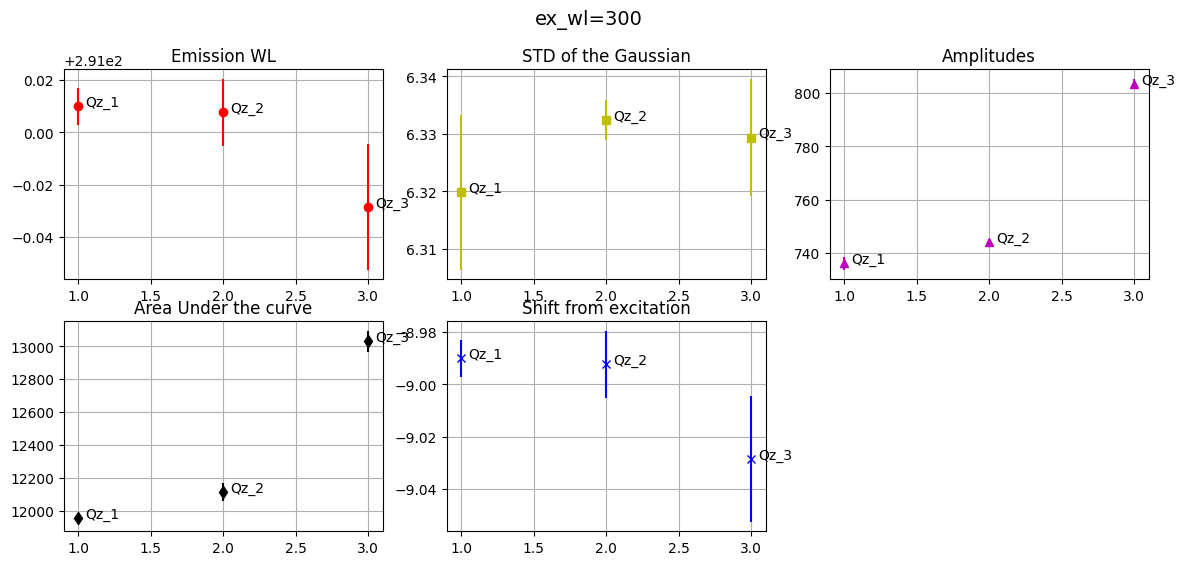

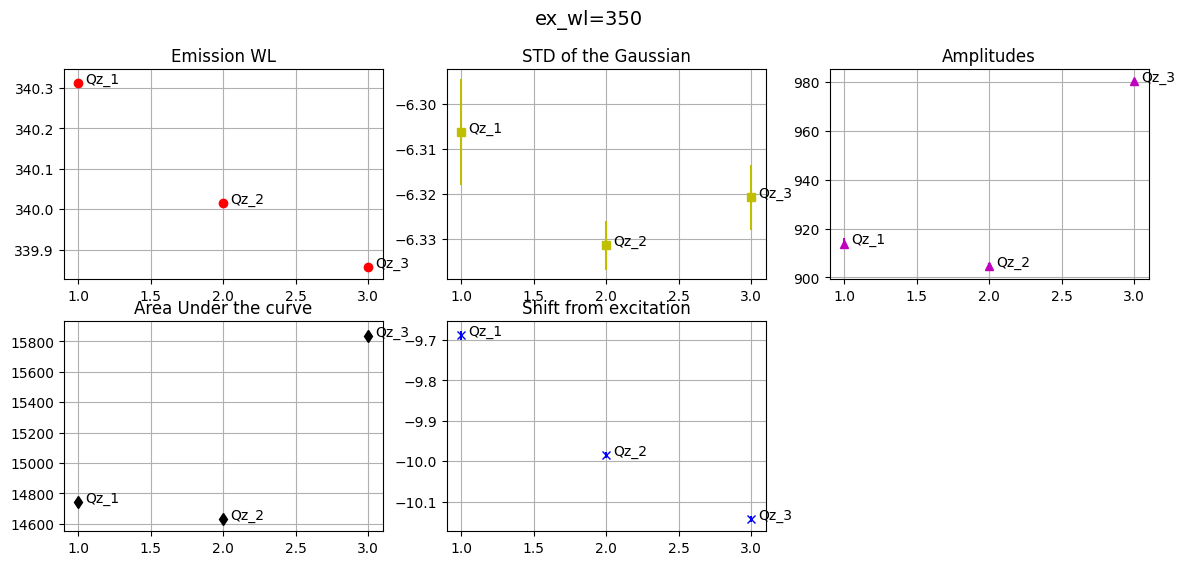

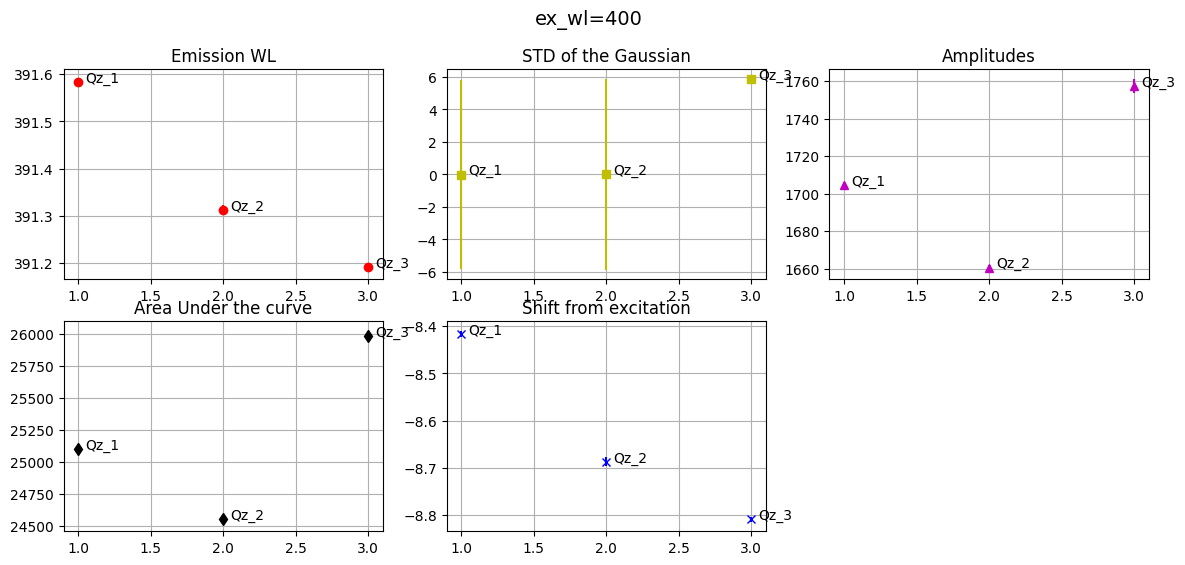

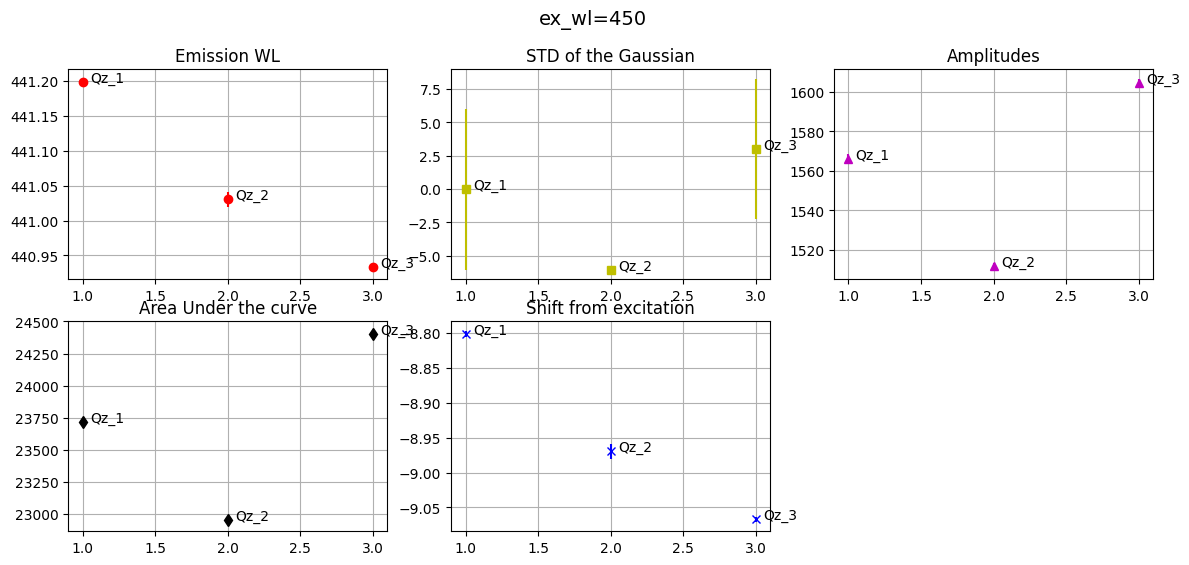

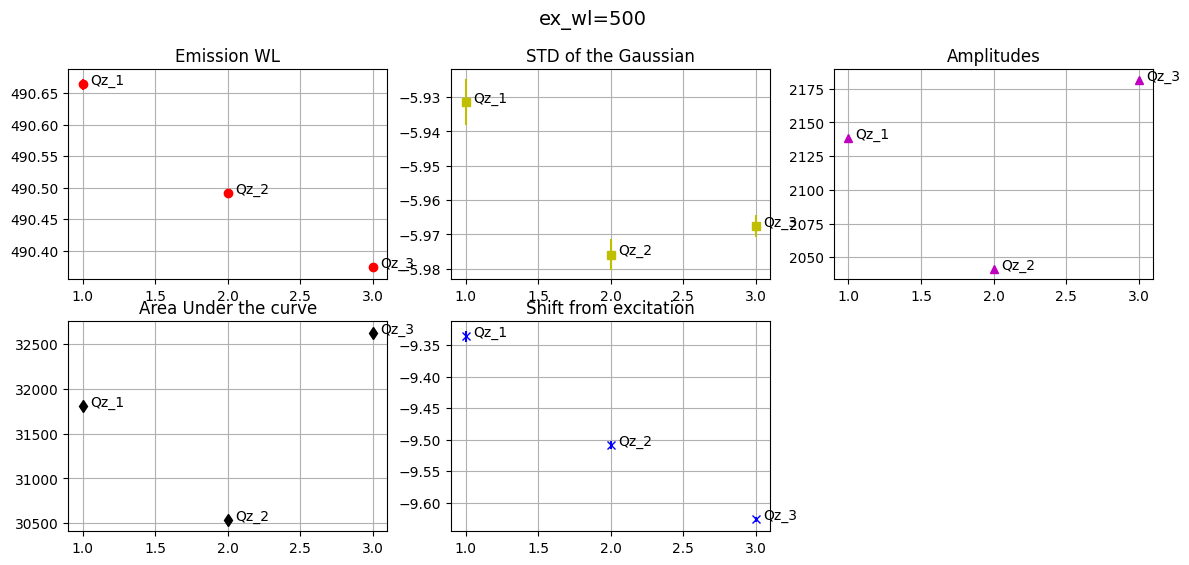

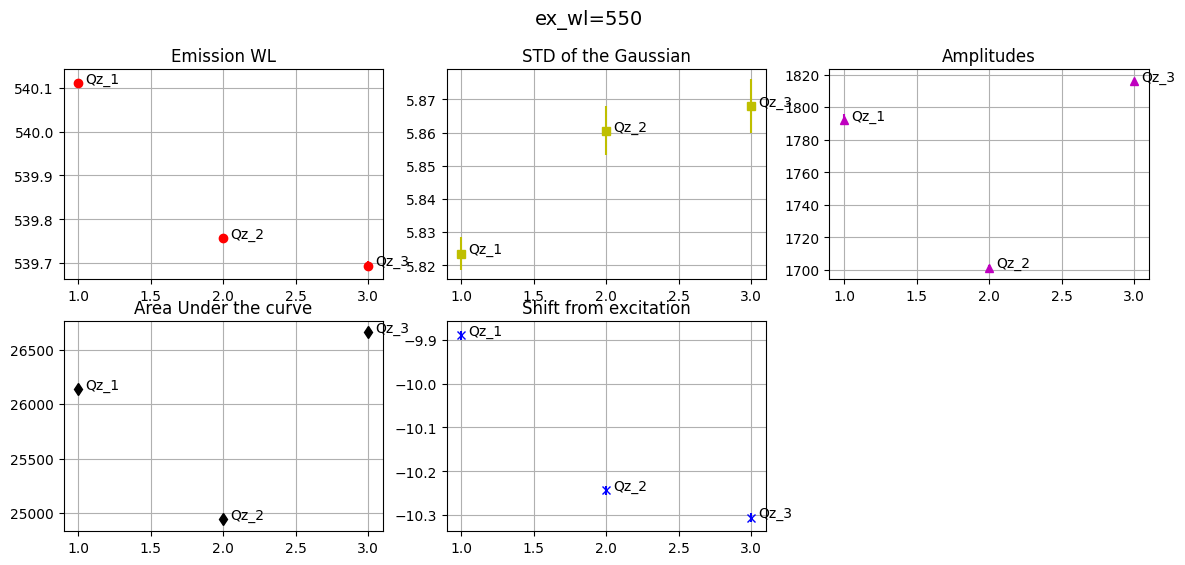

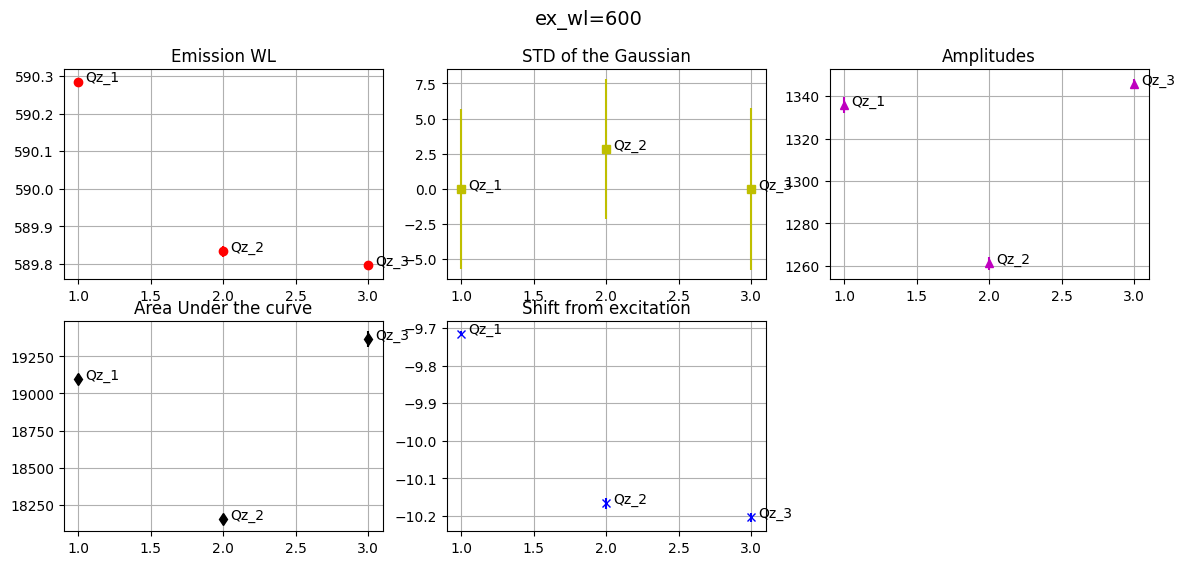

In [32]:
# Plotting desired parameters
plt.rcParams['figure.figsize'] = 14,6 #global value change of the size
i=0

for Cry_col,data in fit_parameters.items():
    i=i+1
    if i%3==0:
        j=3 
    else:
        j= i%3
    
    for ex_wl,param in data.items():
        plt.figure(ex_wl)
        fig = plt.gcf()
        fig.suptitle(f'ex_wl={ex_wl}', fontsize=14)
        plt.figure(ex_wl)
        plt.subplot(2,3,1)
        plt.errorbar(j,param['av_M'],yerr=param['std_M'],xerr=None,fmt='ro')
        plt.title('Emission WL')
        plt.grid()
        plt.text(j+0.05,param['av_M'],Cry_col)
    
        plt.subplot(2,3,2)
        plt.title('STD of the Gaussian')
        plt.grid()
        plt.errorbar(j,param['av_S'],yerr=param['std_S'],xerr=None,fmt='ys')
        plt.text(j+0.05,param['av_S'],Cry_col)
        
        plt.subplot(2,3,3)
        plt.title('Amplitudes')
        plt.grid()
        plt.errorbar(j,param['av_A'],yerr=param['std_A'],xerr=None,fmt='m^')
        plt.text(j+0.05,param['av_A'],Cry_col)
    
        
        plt.subplot(2,3,4)
        plt.title('Area Under the curve')
        plt.grid()
        plt.errorbar(j,param['av_Areas'],yerr=param['std_Areas'],xerr=None,fmt='kd')
        plt.text(j+0.05,param['av_Areas'],Cry_col)
        
        
        plt.subplot(2,3,5)
        plt.title('Shift from excitation')
        plt.grid()
        plt.errorbar(j,param['av_M']-ex_wl,yerr=np.std(param['M']-ex_wl),xerr=None,fmt='bx')
        plt.text(j+0.05,param['av_M']-ex_wl,Cry_col)

        

        
    